In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from numpy.fft import fftn
from collections import defaultdict
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/quantum_data/'
calibration_dir = data_dir + 'calibration_data/'
historic_dir = 'trend_csvs_20190905/All/'
figure_path = '/home/mnewlin/git/AFIT/Thesis/code/figures/quantum_data/'
# Dataset dependent number of cols
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

### T1 times for historic data

In [4]:
t1_boeblingen = data_dir + historic_dir + 't1_boeblingen.csv'
t1_df_initial = pd.read_csv(t1_boeblingen, usecols=['val', 'bit'])
display(t1_df_initial.head())

temp = defaultdict(list)
bits = t1_df_initial.loc[:, 'bit']
vals = t1_df_initial.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
t1_boeblingen_dict = temp

,val,bit
0,83.339771,0
1,57.410816,2
2,67.350505,3
3,97.703239,4
4,69.293859,5


0: 61
1: 61
2: 62
3: 56
4: 50
5: 62
6: 62
7: 57
8: 61
9: 59
10: 62
11: 58
12: 60
13: 61
14: 57
15: 58
16: 61
17: 58
18: 60
19: 62


In [5]:
t1_ourense = data_dir + historic_dir + 't1_ourense.csv'
t1_df_ourense = pd.read_csv(t1_ourense, usecols=['val', 'bit'])
display(t1_df_ourense.head())

temp = defaultdict(list)
bits = t1_df_ourense.loc[:, 'bit']
vals = t1_df_ourense.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
t1_ourense_dict = temp

,val,bit
0,112.065537,0
1,116.711773,2
2,95.234294,4
3,105.277779,1
4,84.178321,3


0: 57
1: 57
2: 62
3: 61
4: 59


In [6]:
t1_poughkeepsie = data_dir + historic_dir + 't1_poughkeepsie.csv'
t1_df_poughkeepsie = pd.read_csv(t1_poughkeepsie, usecols=['val', 'bit'])
display(t1_df_poughkeepsie.head())

temp = defaultdict(list)
bits = t1_df_poughkeepsie.loc[:, 'bit']
vals = t1_df_poughkeepsie.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
t1_poughkeepsie_dict = temp

,val,bit
0,42.105667,0
1,131.466366,17
2,89.706490,16
3,23.855274,15
4,70.639312,14


0: 189
1: 202
2: 208
3: 195
4: 206
5: 191
6: 202
7: 205
8: 208
9: 200
10: 202
11: 211
12: 194
13: 207
14: 200
15: 206
16: 206
17: 211
18: 197
19: 194


In [7]:
from itertools import chain
from operator import methodcaller

def mergeDict(one, two, three):
    ''' Merge dictionaries and keep values of common keys in list'''
    # initialise defaultdict of lists
    dd = defaultdict(list)

    # iterate dictionary items
    dict_items = map(methodcaller('items'), (one, two, three))
    for k, v in chain.from_iterable(dict_items):
        dd[k].extend(v)
    return dd



In [8]:
t1_all_dict = mergeDict(t1_boeblingen_dict,t1_ourense_dict, t1_poughkeepsie_dict)
for key,vals in sorted(t1_all_dict.items()):
    vals = np.ndarray.flatten(np.array(vals))
for key,vals in sorted(t1_all_dict.items()):
    print("{}: {}".format(key, len(vals)))

0: 307
1: 320
2: 332
3: 312
4: 315
5: 253
6: 264
7: 262
8: 269
9: 259
10: 264
11: 269
12: 254
13: 268
14: 257
15: 264
16: 267
17: 269
18: 257
19: 256


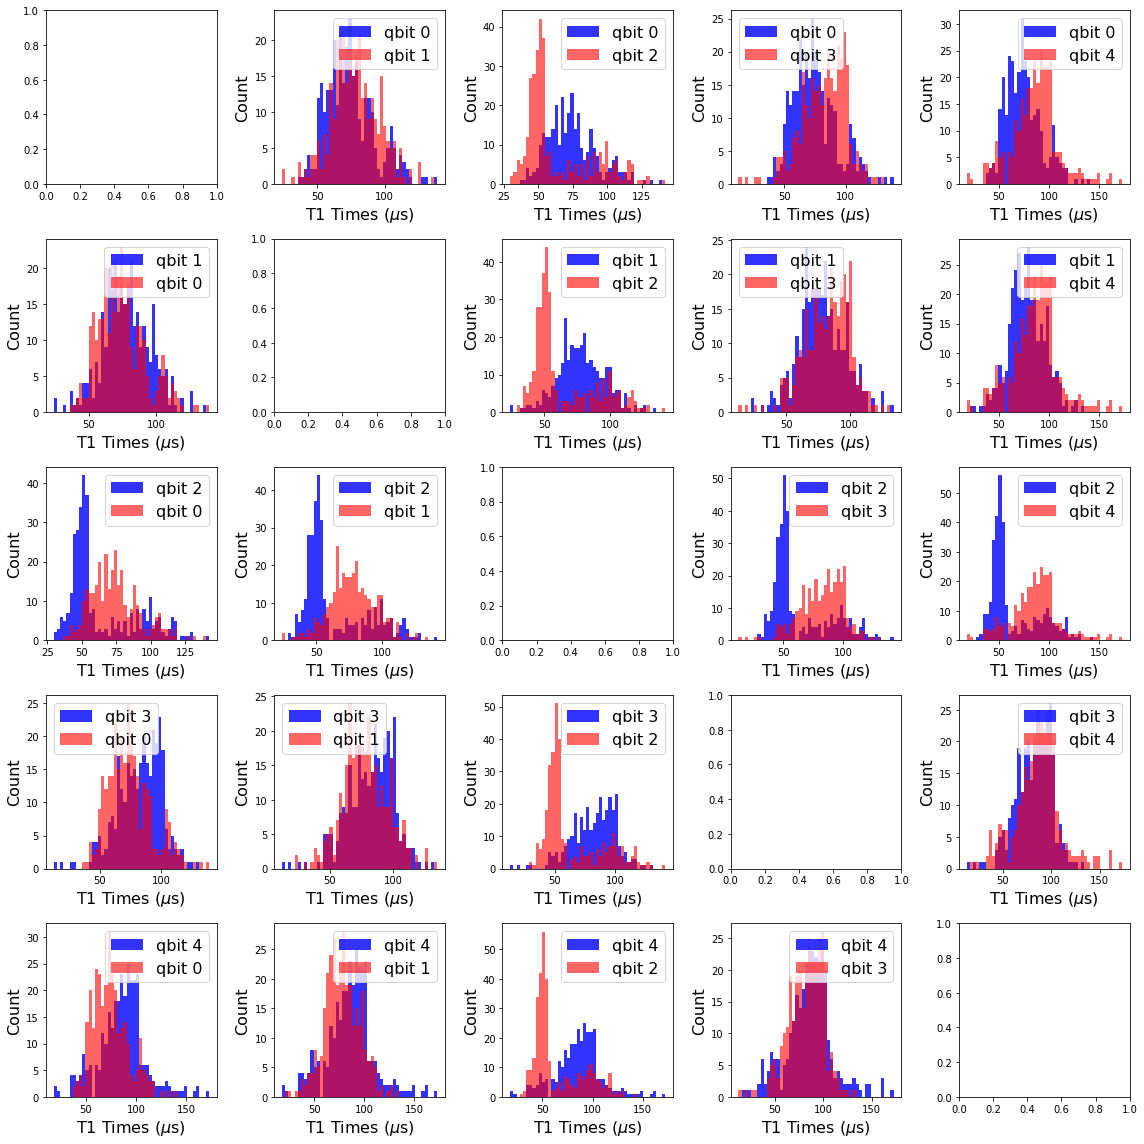

In [9]:



qbit_data_all = []
for x in range(5):
    qbit_data_all.append(t1_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(16,16))
alpha_blue = 0.8
alpha_red = 0.6
grid_x = 5
grid_y = 5
binsize = 50
grid = mpl.gridspec.GridSpec(grid_x, grid_y)

count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.multiply(np.array(t1_all_dict[i]), 1e0)
            qbit_j = np.multiply(np.array(t1_all_dict[j]), 1e0)
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = ax1.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i), density=False)
            temp_red = ax1.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j), density=False)
            ax1.set_xlabel(r'T1 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't1_ibm_qbit0-4.pdf')
plt.savefig(figure_path + 't1_ibm_qbit0-4.png')
plt.show()

In [10]:
JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i,j))
            JSD_scores_list.append(JSD_scores[i,j])
t1_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['jensenshannonD'])        

display(t1_jsd_df)

,jensenshannonD
qbit 0-1,0.303958
qbit 0-2,0.564816
qbit 0-3,0.390063
qbit 0-4,0.431331
qbit 1-0,0.303958
qbit 1-2,0.587795
qbit 1-3,0.262780
qbit 1-4,0.319706
qbit 2-0,0.564816
qbit 2-1,0.587795


### Qubit 5-10

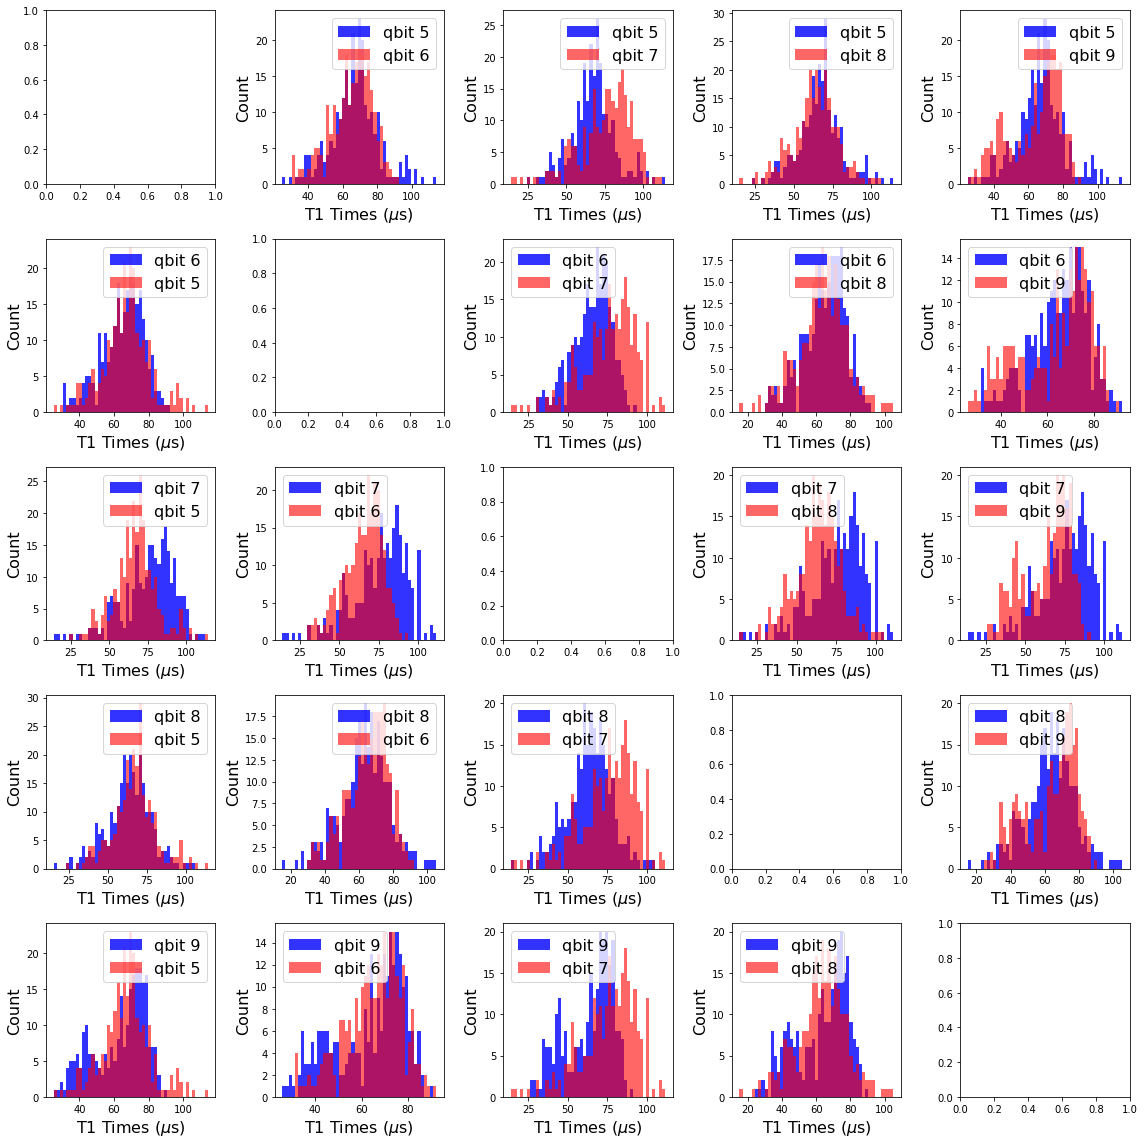

,KLD
qbit 5-6,0.278060
qbit 5-7,0.450611
qbit 5-8,0.248164
qbit 5-9,0.340891
qbit 6-5,0.278060
qbit 6-7,0.482936
qbit 6-8,0.223598
qbit 6-9,0.331187
qbit 7-5,0.450611
qbit 7-6,0.482936


In [11]:

qbit_data_all = []
for x in range(5,10):
    qbit_data_all.append(t1_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(16,16))
alpha_blue = 0.8
alpha_red = 0.6
grid_x = 5
grid_y = 5
binsize = 50
grid = mpl.gridspec.GridSpec(grid_x, grid_y)

count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.multiply(np.array(qbit_data_all[i]), 1e0)
            qbit_j = np.multiply(np.array(qbit_data_all[j]), 1e0)
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = ax1.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+5), density=False)
            temp_red = ax1.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+5), density=False)
            ax1.set_xlabel(r'T1 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't1_ibm_qbit5-9.pdf')
plt.savefig(figure_path + 't1_ibm_qbit5-9.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+5,j+5))
            JSD_scores_list.append(JSD_scores[i,j])
t1_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(t1_jsd_df)

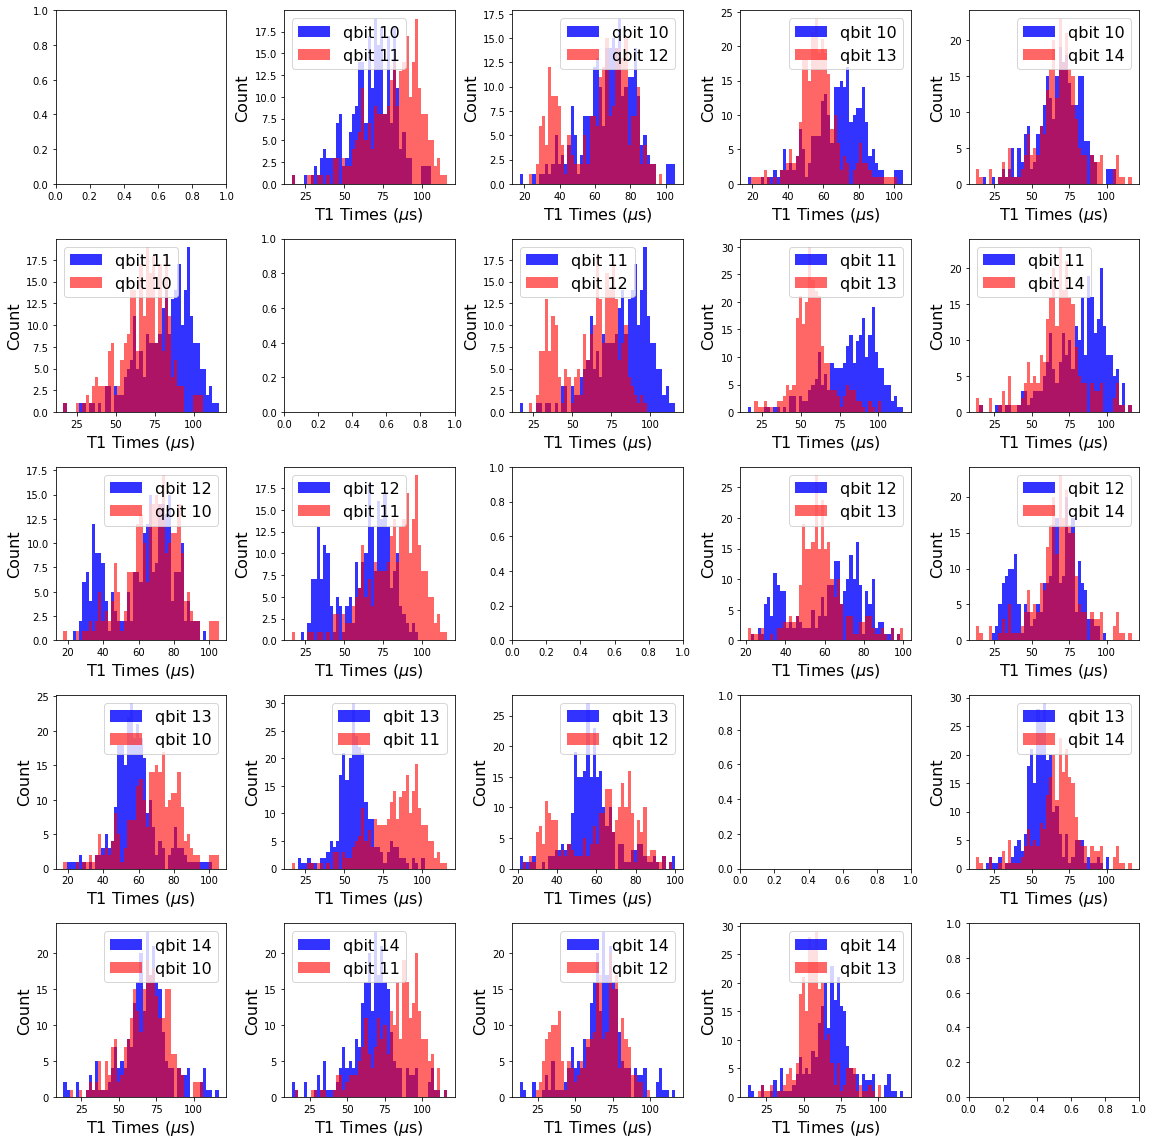

,KLD
qbit 10-11,0.481912
qbit 10-12,0.323989
qbit 10-13,0.466582
qbit 10-14,0.319082
qbit 11-10,0.481912
qbit 11-12,0.558933
qbit 11-13,0.638968
qbit 11-14,0.488609
qbit 12-10,0.323989
qbit 12-11,0.558933


In [12]:

qbit_data_all = []
for x in range(10,15):
    qbit_data_all.append(t1_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(16,16))
alpha_blue = 0.8
alpha_red = 0.6
grid_x = 5
grid_y = 5
binsize = 50
grid = mpl.gridspec.GridSpec(grid_x, grid_y)

count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.multiply(np.array(qbit_data_all[i]), 1e0)
            qbit_j = np.multiply(np.array(qbit_data_all[j]), 1e0)
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = ax1.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+10), density=False)
            temp_red = ax1.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+10), density=False)
            ax1.set_xlabel(r'T1 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't1_ibm_qbit10-14.pdf')
plt.savefig(figure_path + 't1_ibm_qbit10-14.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+10,j+10))
            JSD_scores_list.append(JSD_scores[i,j])
t1_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(t1_jsd_df)

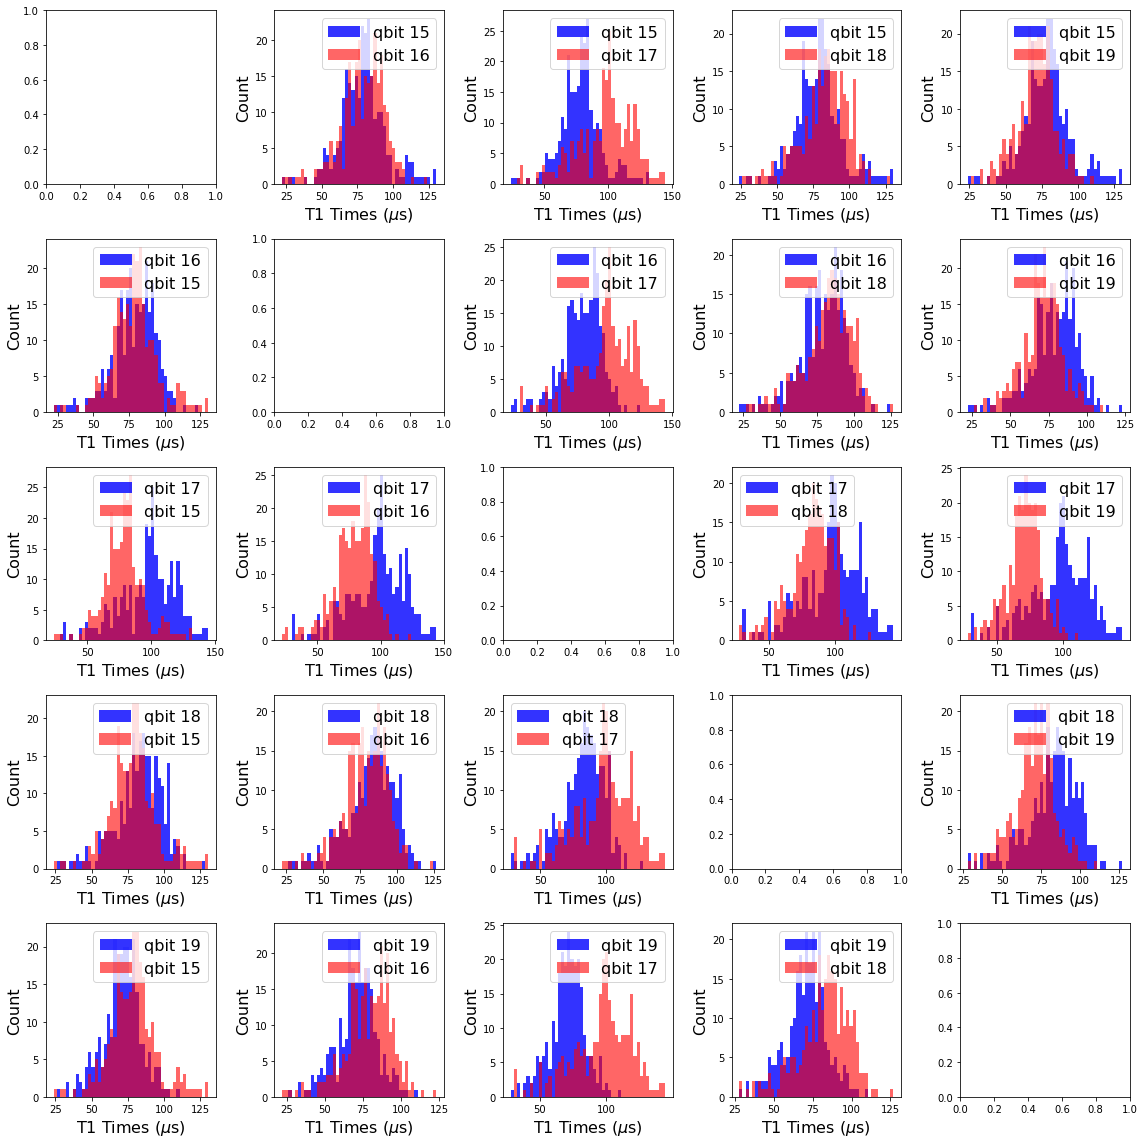

,KLD
qbit 15-16,0.312544
qbit 15-17,0.546138
qbit 15-18,0.348750
qbit 15-19,0.325588
qbit 16-15,0.312544
qbit 16-17,0.565449
qbit 16-18,0.273916
qbit 16-19,0.379353
qbit 17-15,0.546138
qbit 17-16,0.565449


In [13]:

qbit_data_all = []
for x in range(15,20):
    qbit_data_all.append(t1_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(16,16))
alpha_blue = 0.8
alpha_red = 0.6
grid_x = 5
grid_y = 5
binsize = 50
grid = mpl.gridspec.GridSpec(grid_x, grid_y)

count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.multiply(np.array(qbit_data_all[i]), 1e0)
            qbit_j = np.multiply(np.array(qbit_data_all[j]), 1e0)
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = ax1.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+15), density=False)
            temp_red = ax1.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+15), density=False)
            ax1.set_xlabel(r'T1 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't1_ibm_qbit15-19.pdf')
plt.savefig(figure_path + 't1_ibm_qbit15-19.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+15,j+15))
            JSD_scores_list.append(JSD_scores[i,j])
t1_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(t1_jsd_df)

## T2 Frequencies

In [14]:
t2_boeblingen = data_dir + historic_dir + 't2_boeblingen.csv'
t2_df_initial = pd.read_csv(t2_boeblingen, usecols=['val', 'bit'])
display(t2_df_initial.head())

temp = defaultdict(list)
bits = t2_df_initial.loc[:, 'bit']
vals = t2_df_initial.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
t2_boeblingen_dict = temp

,val,bit
0,108.815111,0
1,78.117249,2
2,122.035731,19
3,161.113979,4
4,77.607305,5


0: 61
1: 63
2: 63
3: 62
4: 62
5: 63
6: 63
7: 63
8: 63
9: 62
10: 63
11: 62
12: 63
13: 62
14: 60
15: 61
16: 63
17: 63
18: 63
19: 61


In [15]:
t2_ourense = data_dir + historic_dir + 't2_ourense.csv'
t2_df_ourense = pd.read_csv(t2_ourense, usecols=['val', 'bit'])
display(t2_df_ourense.head())

temp = defaultdict(list)
bits = t2_df_ourense.loc[:, 'bit']
vals = t2_df_ourense.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
t2_ourense_dict = temp

,val,bit
0,63.519172,0
1,67.413019,3
2,87.062089,2
3,47.582568,4
4,23.835415,1


0: 65
1: 65
2: 65
3: 64
4: 65


In [16]:
t2_poughkeepsie = data_dir + historic_dir + 't2_poughkeepsie.csv'
t2_df_poughkeepsie = pd.read_csv(t2_poughkeepsie, usecols=['val', 'bit'])
display(t2_df_poughkeepsie.head())

temp = defaultdict(list)
bits = t2_df_poughkeepsie.loc[:, 'bit']
vals = t2_df_poughkeepsie.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
t2_poughkeepsie_dict = temp

,val,bit
0,43.917066,0
1,68.913860,4
2,95.475760,6
3,53.499963,8
4,101.911242,18


0: 210
1: 210
2: 209
3: 210
4: 210
5: 206
6: 210
7: 14
8: 209
9: 209
10: 199
11: 213
12: 154
13: 21
14: 211
15: 191
16: 214
17: 197
18: 210
19: 207


In [17]:
t2_all_dict = mergeDict(t2_boeblingen_dict,t2_ourense_dict, t2_poughkeepsie_dict)
for key,vals in sorted(t2_all_dict.items()):
    vals = np.ndarray.flatten(np.array(vals))
for key,vals in sorted(t2_all_dict.items()):
    print("{}: {}".format(key, len(vals)))

0: 336
1: 338
2: 337
3: 336
4: 337
5: 269
6: 273
7: 77
8: 272
9: 271
10: 262
11: 275
12: 217
13: 83
14: 271
15: 252
16: 277
17: 260
18: 273
19: 268


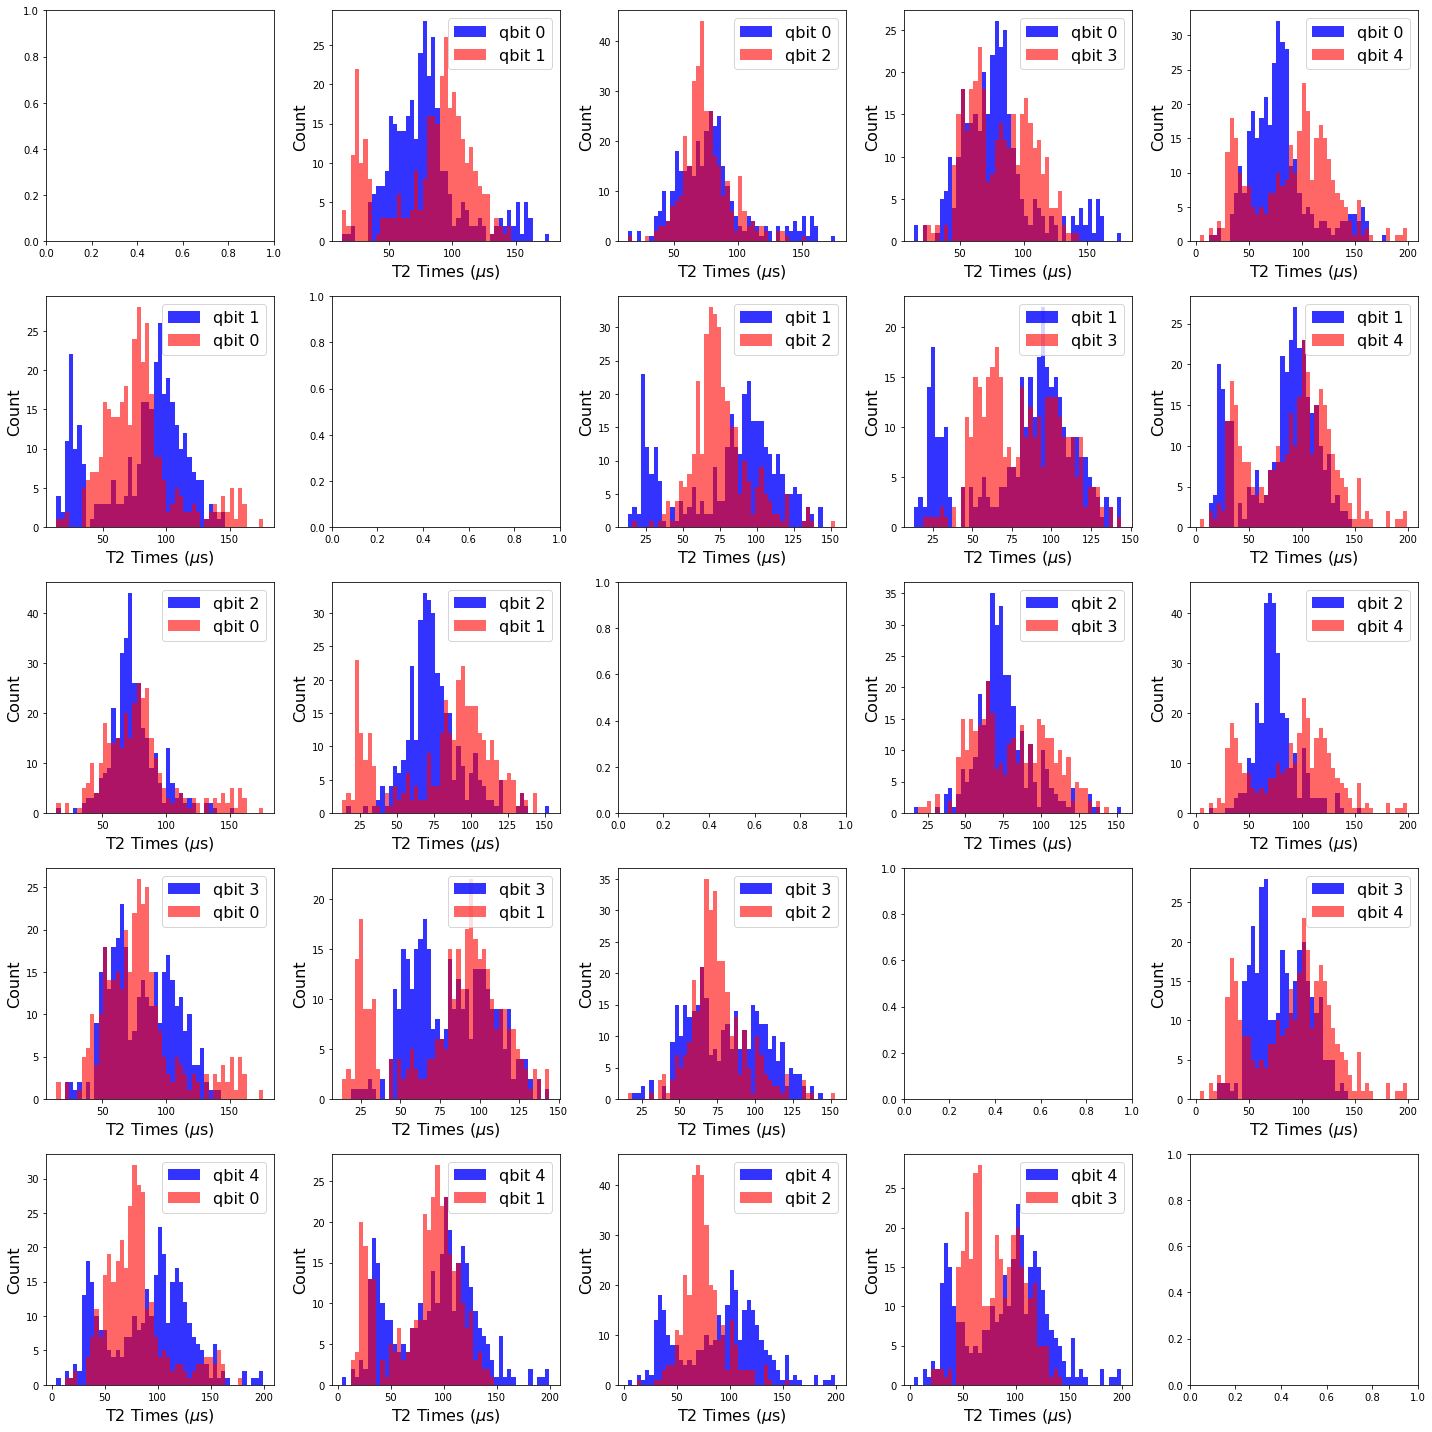

In [18]:
qbit_data_all = []
for x in range(5):
    qbit_data_all.append(t2_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.array(t2_all_dict[i])
            qbit_j = np.array(t2_all_dict[j])
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j))
            ax1.set_xlabel(r'T2 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't2_ibm_qbit0-4.pdf')
plt.savefig(figure_path + 't2_ibm_qbit0-4.png')
plt.show()

In [19]:
JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i,j))
            JSD_scores_list.append(JSD_scores[i,j])
t2_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(t2_jsd_df)

,KLD
qbit 0-1,0.539260
qbit 0-2,0.325542
qbit 0-3,0.394647
qbit 0-4,0.488434
qbit 1-0,0.539260
qbit 1-2,0.583043
qbit 1-3,0.429318
qbit 1-4,0.365338
qbit 2-0,0.325542
qbit 2-1,0.583043


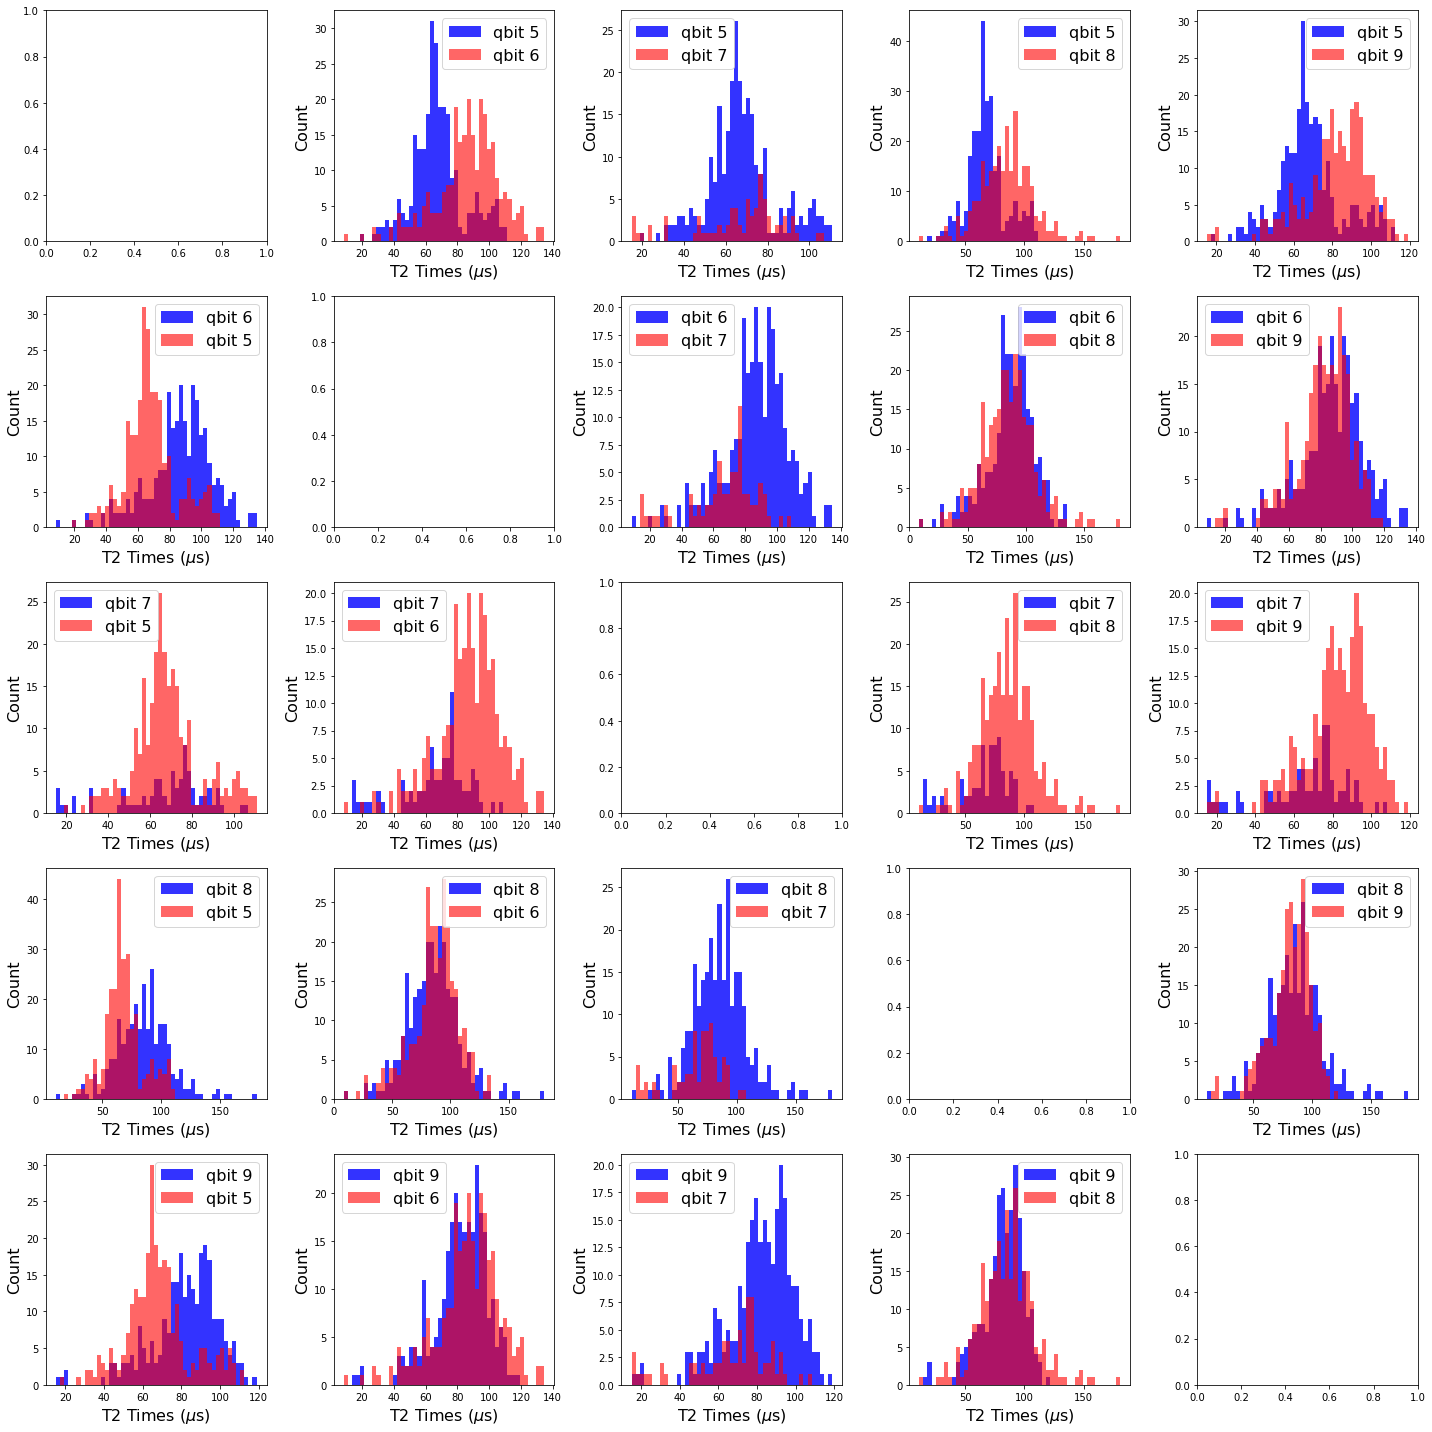

,KLD
qbit 5-6,0.543209
qbit 5-7,0.469652
qbit 5-8,0.449200
qbit 5-9,0.500712
qbit 6-5,0.543209
qbit 6-7,0.571187
qbit 6-8,0.248477
qbit 6-9,0.273281
qbit 7-5,0.469652
qbit 7-6,0.571187


In [20]:
qbit_data_all = []
for x in range(5,10):
    qbit_data_all.append(t2_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 5
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.array(qbit_data_all[i])
            qbit_j = np.array(qbit_data_all[j])
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel(r'T2 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't2_ibm_qbit5-9.pdf')
plt.savefig(figure_path + 't2_ibm_qbit5-9.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
t2_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(t2_jsd_df)

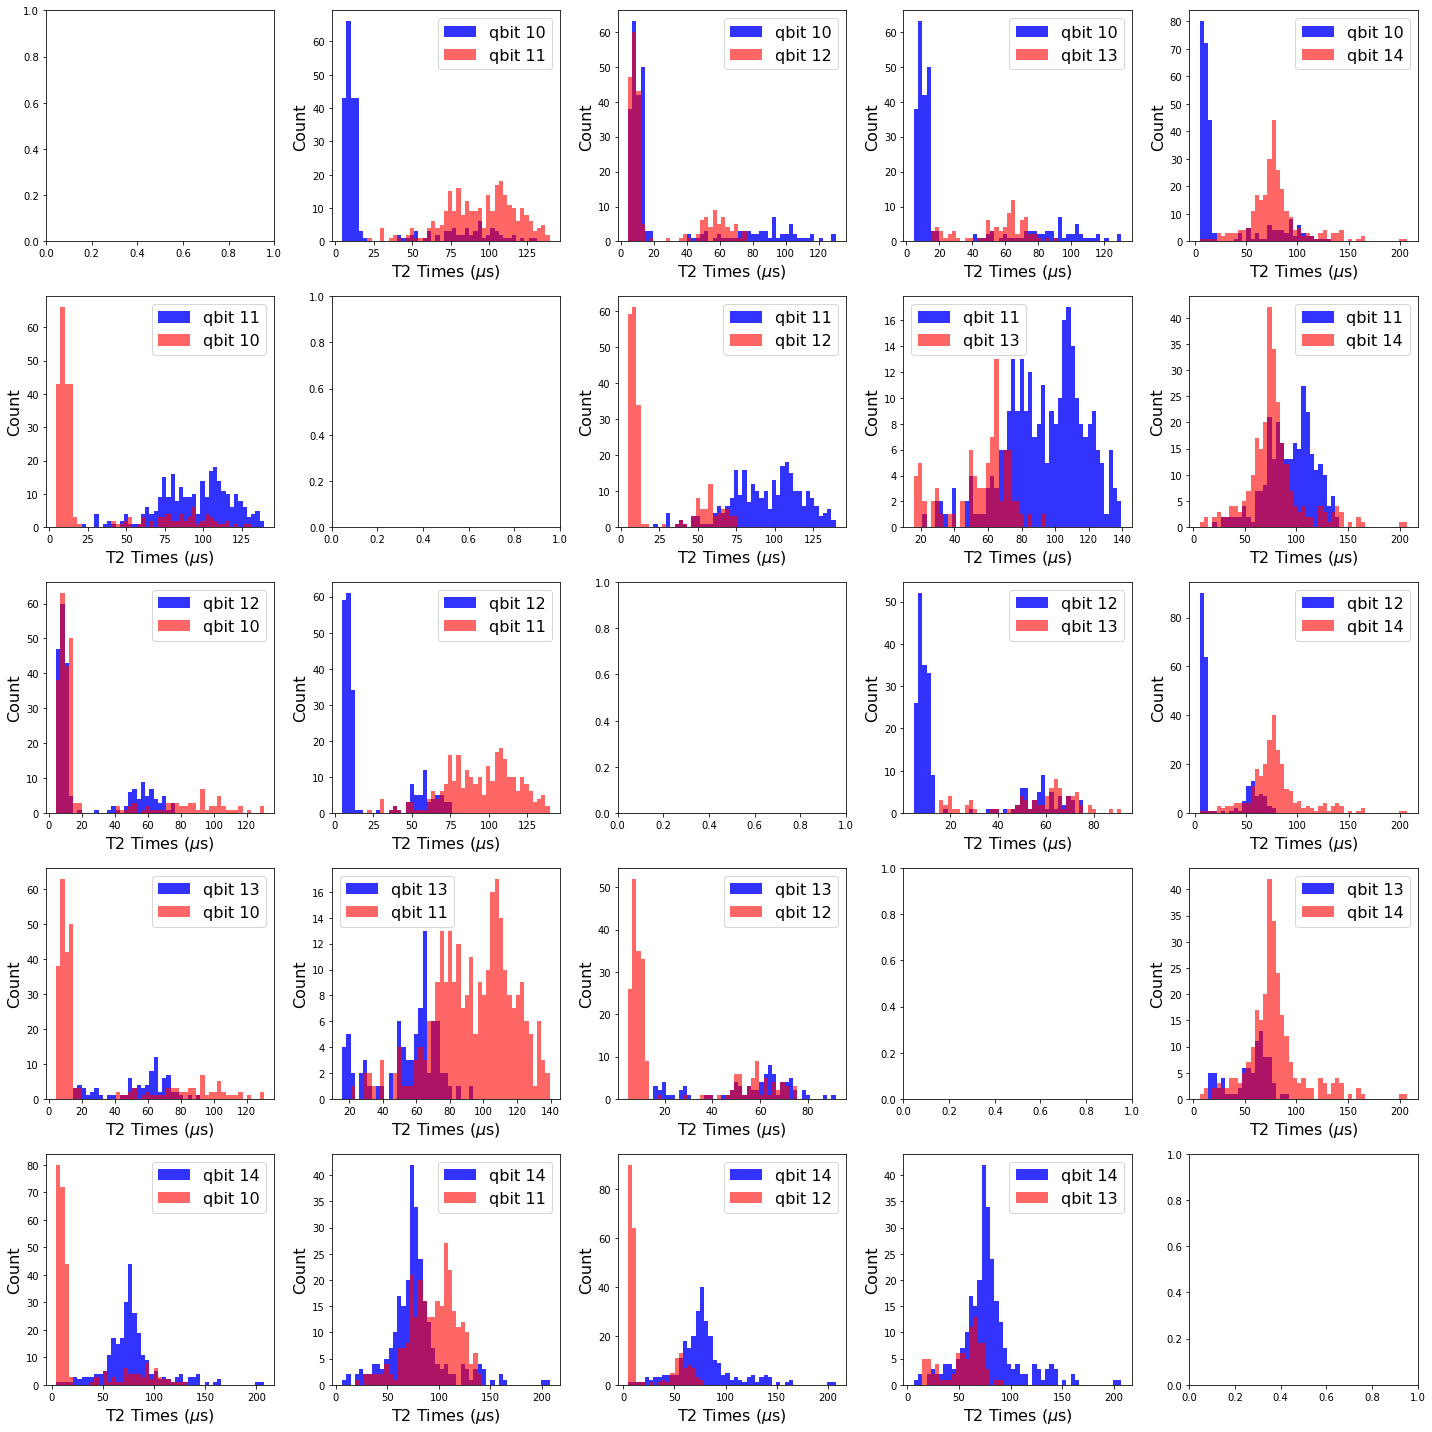

,KLD
qbit 10-11,0.791617
qbit 10-12,0.462897
qbit 10-13,0.869838
qbit 10-14,0.768225
qbit 11-10,0.791617
qbit 11-12,0.898983
qbit 11-13,0.768590
qbit 11-14,0.457258
qbit 12-10,0.462897
qbit 12-11,0.898983


In [21]:
qbit_data_all = []
for x in range(10,15):
    qbit_data_all.append(t2_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 10
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.array(qbit_data_all[i])
            qbit_j = np.array(qbit_data_all[j])
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel(r'T2 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't2_ibm_qbit10-14.pdf')
plt.savefig(figure_path + 't2_ibm_qbit10-14.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
t2_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(t2_jsd_df)

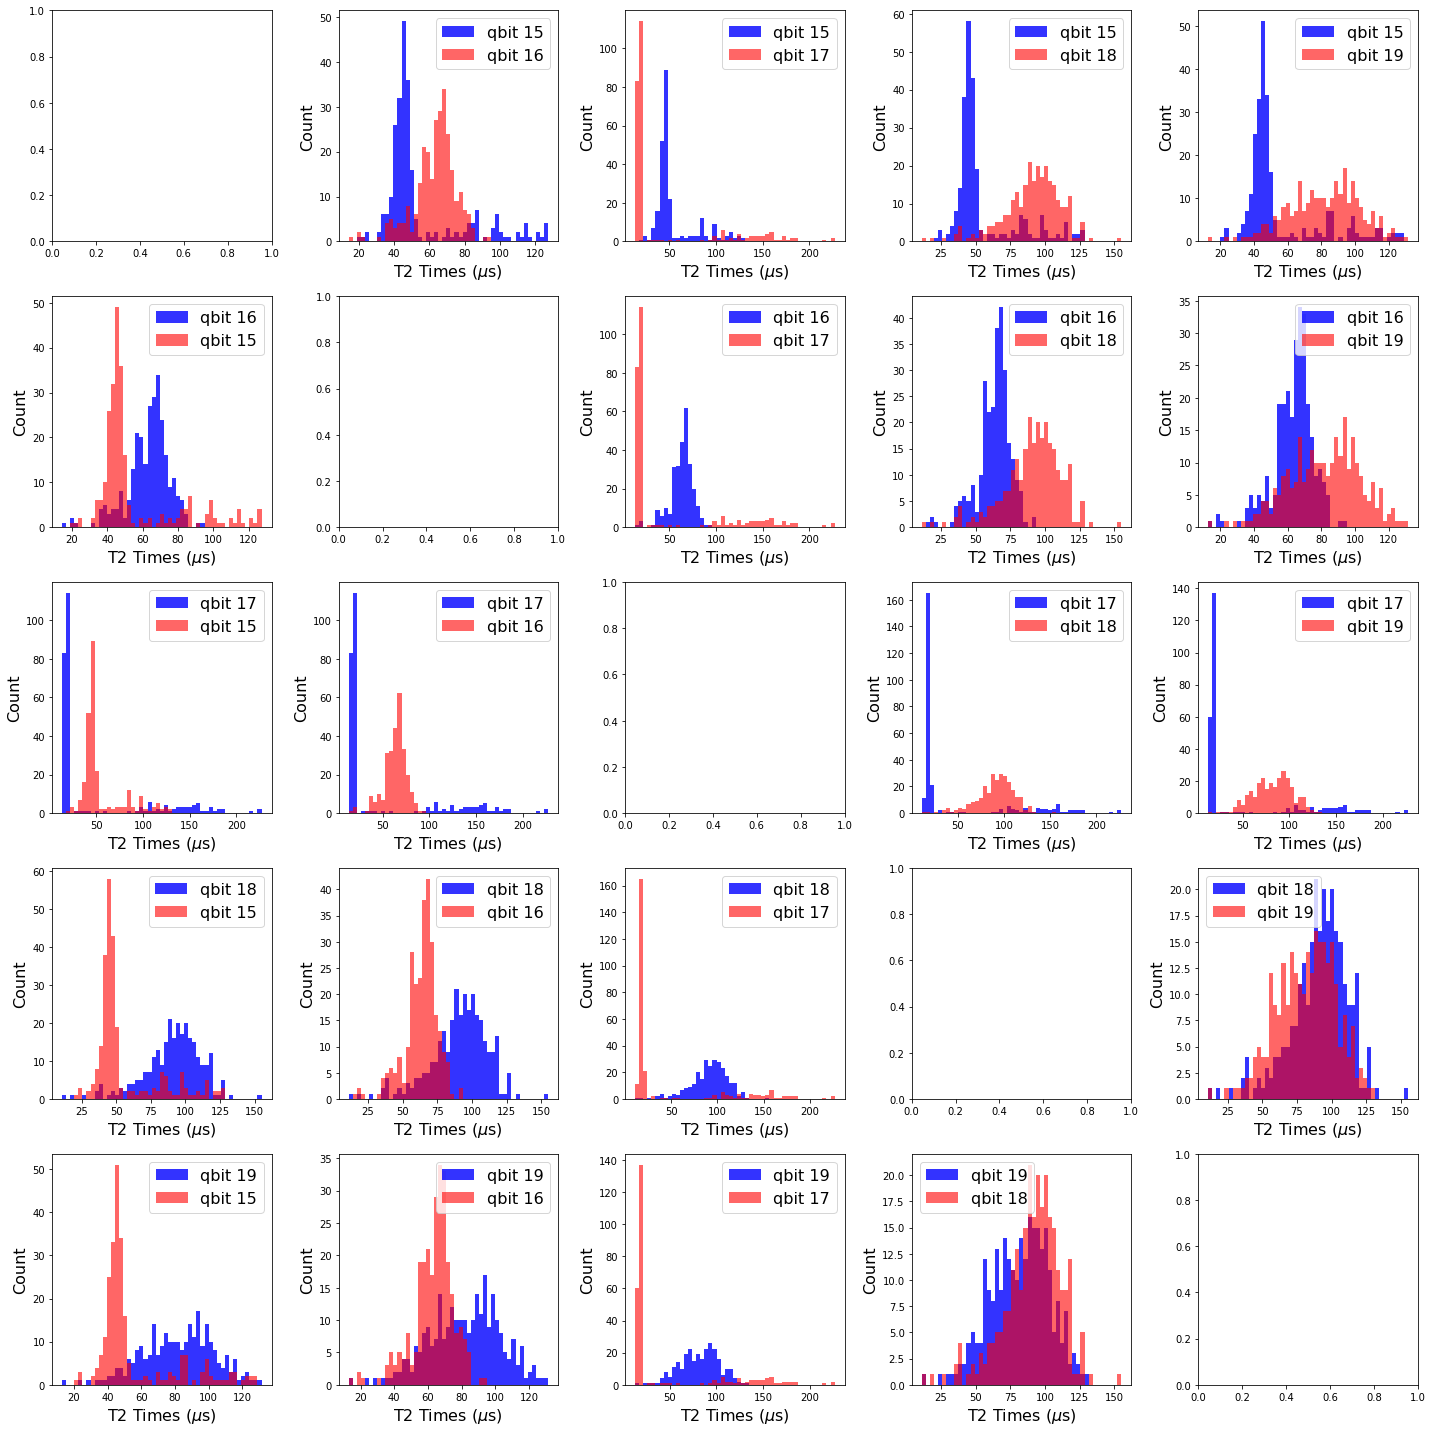

,KLD
qbit 15-16,0.754564
qbit 15-17,0.917297
qbit 15-18,0.732854
qbit 15-19,0.682693
qbit 16-15,0.754564
qbit 16-17,0.947092
qbit 16-18,0.735773
qbit 16-19,0.575764
qbit 17-15,0.917297
qbit 17-16,0.947092


In [22]:
qbit_data_all = []
for x in range(15,20):
    qbit_data_all.append(t2_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 15
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.array(qbit_data_all[i])
            qbit_j = np.array(qbit_data_all[j])
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel(r'T2 Times ($\mu$s)', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 't2_ibm_qbit15-19.pdf')
plt.savefig(figure_path + 't2_ibm_qbit15-19.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
t2_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(t2_jsd_df)

## Readout Error

In [23]:
readout_fid_boeblingen = data_dir + historic_dir + 'readout_fid_boeblingen.csv'
readout_fid_df_initial = pd.read_csv(readout_fid_boeblingen, usecols=['val', 'bit'])
display(readout_fid_df_initial.head())

temp = defaultdict(list)
bits = readout_fid_df_initial.loc[:, 'bit']
vals = readout_fid_df_initial.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
readout_fid_boeblingen_dict = temp

,val,bit
0,0.965000,0
1,0.935000,2
2,0.918333,3
3,0.951667,4
4,0.973333,5


0: 72
1: 72
2: 72
3: 72
4: 73
5: 71
6: 72
7: 72
8: 72
9: 72
10: 72
11: 75
12: 72
13: 73
14: 72
15: 72
16: 72
17: 72
18: 72
19: 72


In [24]:
readout_fid_ourense = data_dir + historic_dir + 'readout_fid_ourense.csv'
readout_fid_df_ourense = pd.read_csv(readout_fid_ourense, usecols=['val', 'bit'])
display(readout_fid_df_ourense.head())

temp = defaultdict(list)
bits = readout_fid_df_ourense.loc[:, 'bit']
vals = readout_fid_df_ourense.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
readout_fid_ourense_dict = temp

,val,bit
0,0.945,0
1,0.964,3
2,0.941,2
3,0.976,4
4,0.954,1


0: 74
1: 74
2: 74
3: 74
4: 74


In [25]:
readout_fid_poughkeepsie = data_dir + historic_dir + 'readout_fid_poughkeepsie.csv'
readout_fid_df_poughkeepsie = pd.read_csv(readout_fid_poughkeepsie, usecols=['val', 'bit'])
display(readout_fid_df_poughkeepsie.head())

temp = defaultdict(list)
bits = readout_fid_df_poughkeepsie.loc[:, 'bit']
vals = readout_fid_df_poughkeepsie.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
readout_fid_poughkeepsie_dict = temp

,val,bit
0,0.9190,19
1,0.9525,19
2,0.9670,19
3,0.9650,19
4,0.9500,19


19: 228


In [26]:
readout_fid_all_dict = mergeDict(readout_fid_boeblingen_dict,readout_fid_ourense_dict, readout_fid_poughkeepsie_dict)
for key,vals in sorted(readout_fid_all_dict.items()):
    vals = np.ndarray.flatten(np.array(vals))
for key,vals in sorted(readout_fid_all_dict.items()):
    print("{}: {}".format(key, len(vals)))

0: 146
1: 146
2: 146
3: 146
4: 147
5: 71
6: 72
7: 72
8: 72
9: 72
10: 72
11: 75
12: 72
13: 73
14: 72
15: 72
16: 72
17: 72
18: 72
19: 300


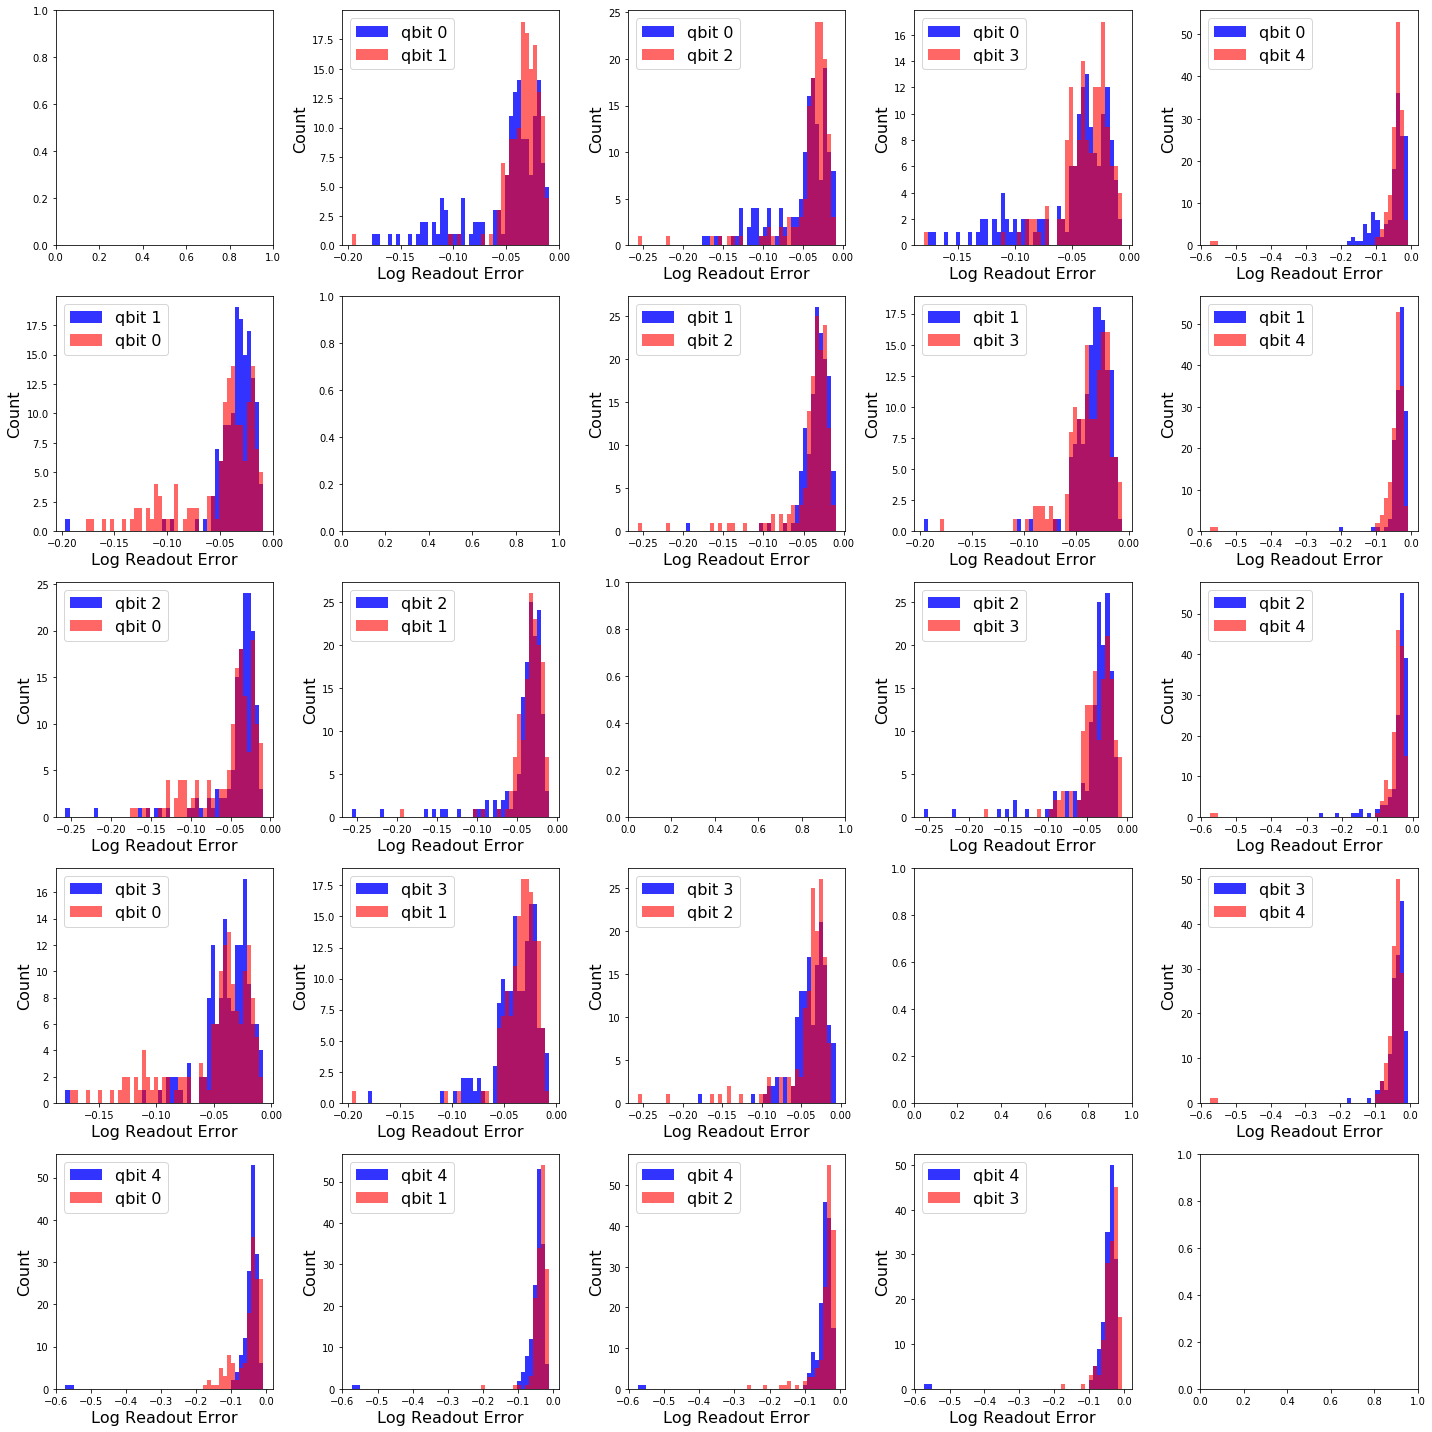

In [27]:
qbit_data_all = []
for x in range(5):
    qbit_data_all.append(readout_fid_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(readout_fid_all_dict[i]))
            qbit_j = np.log(np.array(readout_fid_all_dict[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j))
            ax1.set_xlabel('Log Readout Error', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'readout_fid_ibm_qbit0-4.pdf')
plt.savefig(figure_path + 'readout_fid_ibm_qbit0-4.png')
plt.show()

In [28]:
JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i,j))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

,KLD
qbit 0-1,0.411540
qbit 0-2,0.366029
qbit 0-3,0.366678
qbit 0-4,0.374277
qbit 1-0,0.411540
qbit 1-2,0.281358
qbit 1-3,0.307678
qbit 1-4,0.344925
qbit 2-0,0.366029
qbit 2-1,0.281358


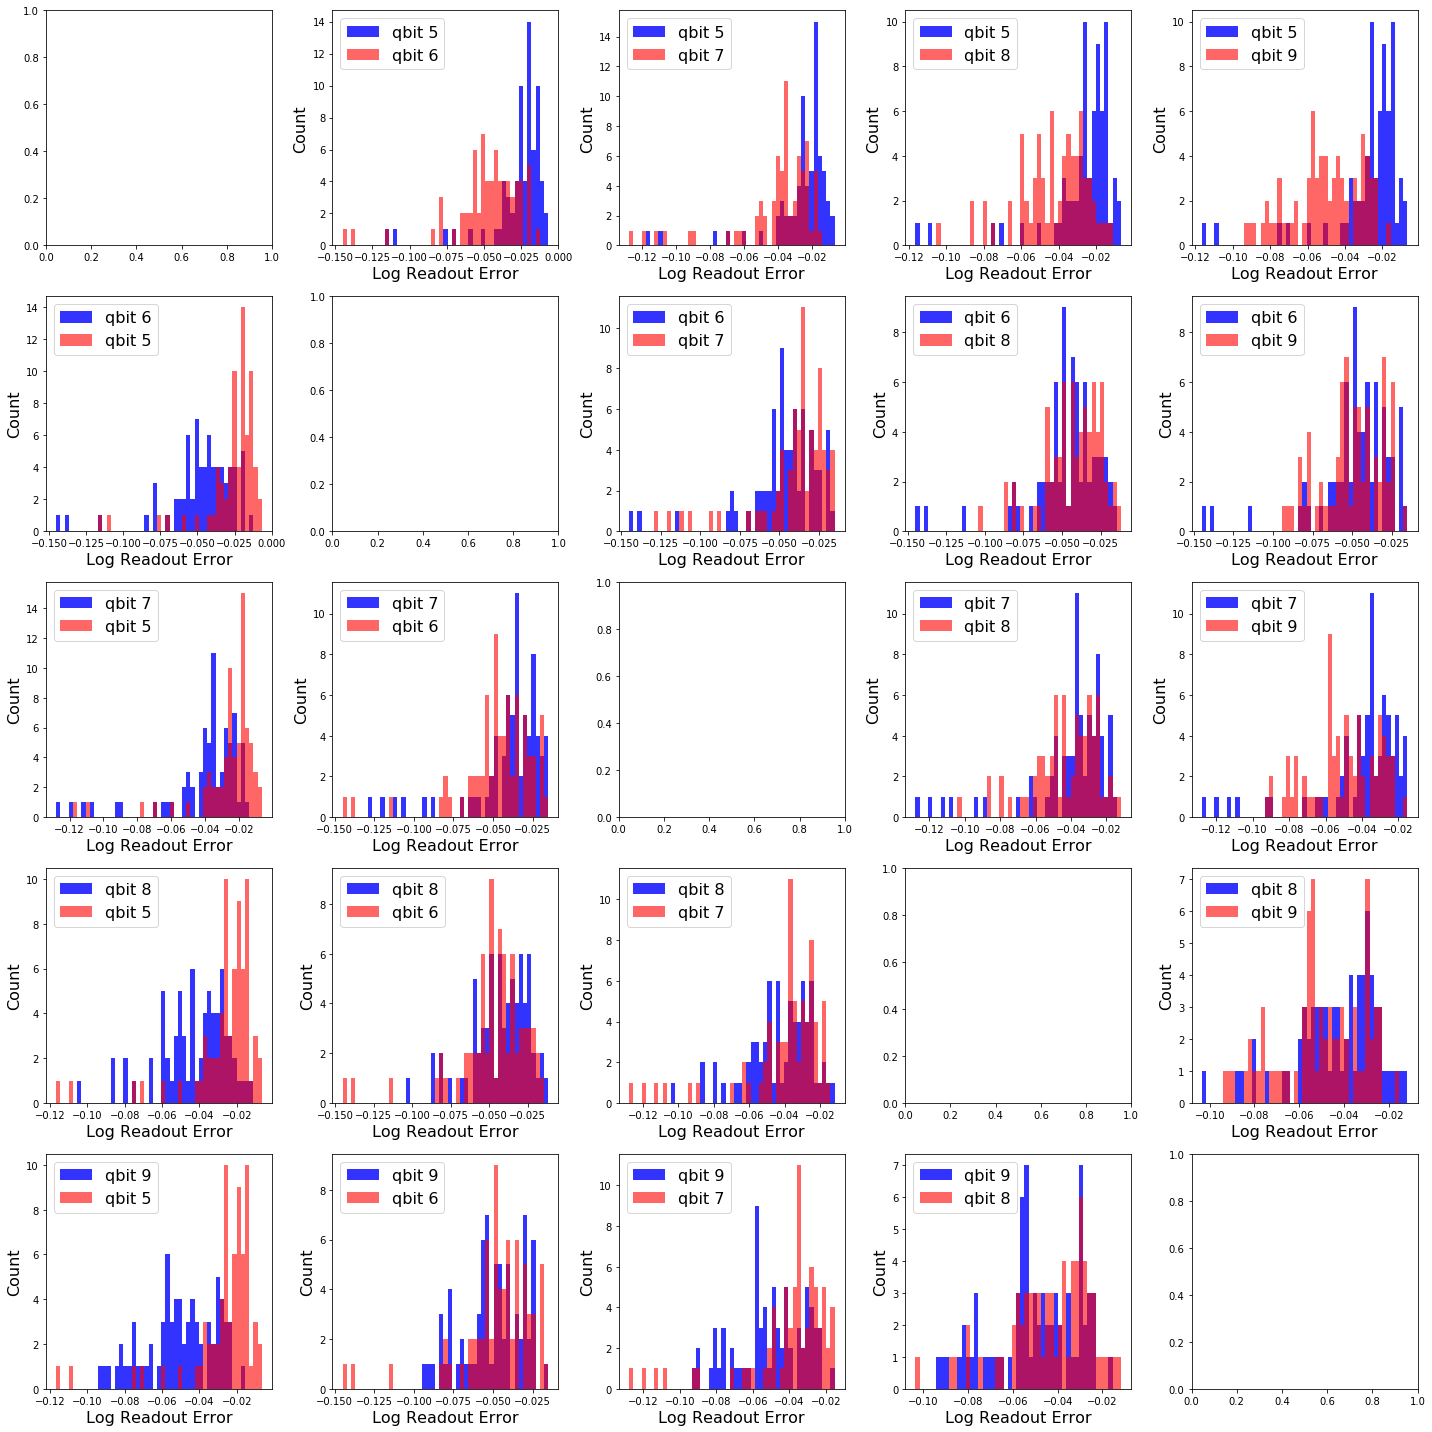

,KLD
qbit 5-6,0.667391
qbit 5-7,0.570660
qbit 5-8,0.628603
qbit 5-9,0.755956
qbit 6-5,0.667391
qbit 6-7,0.498016
qbit 6-8,0.377916
qbit 6-9,0.420078
qbit 7-5,0.570660
qbit 7-6,0.498016


In [29]:
qbit_data_all = []
for x in range(5,10):
    qbit_data_all.append(readout_fid_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 5
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(qbit_data_all[i]))
            qbit_j = np.log(np.array(qbit_data_all[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel('Log Readout Error', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'readout_fid_ibm_qbit5-9.pdf')
plt.savefig(figure_path + 'readout_fid_ibm_qbit5-9.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

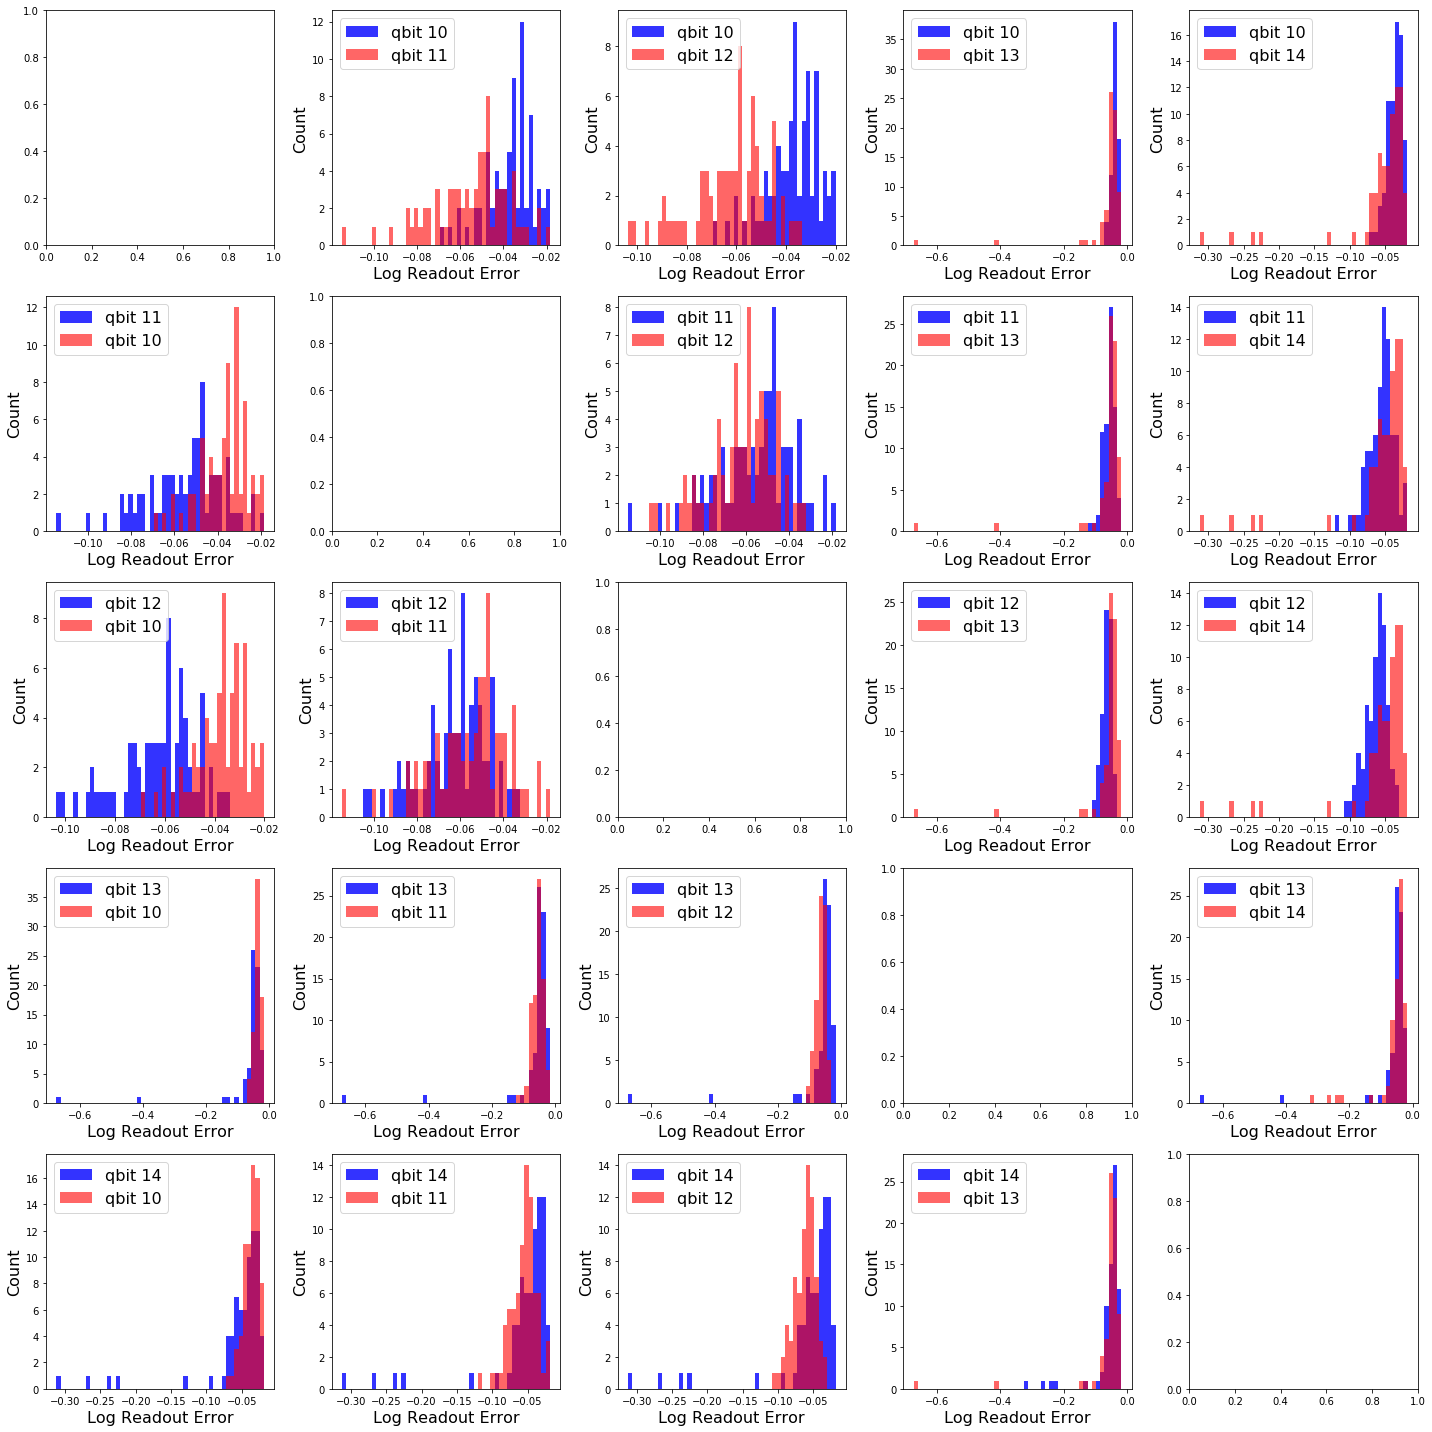

,KLD
qbit 10-11,0.630168
qbit 10-12,0.794092
qbit 10-13,0.352501
qbit 10-14,0.316100
qbit 11-10,0.630168
qbit 11-12,0.527824
qbit 11-13,0.313731
qbit 11-14,0.441497
qbit 12-10,0.794092
qbit 12-11,0.527824


In [30]:
qbit_data_all = []
for x in range(10,15):
    qbit_data_all.append(readout_fid_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 10
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(qbit_data_all[i]))
            qbit_j = np.log(np.array(qbit_data_all[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel('Log Readout Error', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'readout_fid_ibm_qbit10-14.pdf')
plt.savefig(figure_path + 'readout_fid_ibm_qbit10-14.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

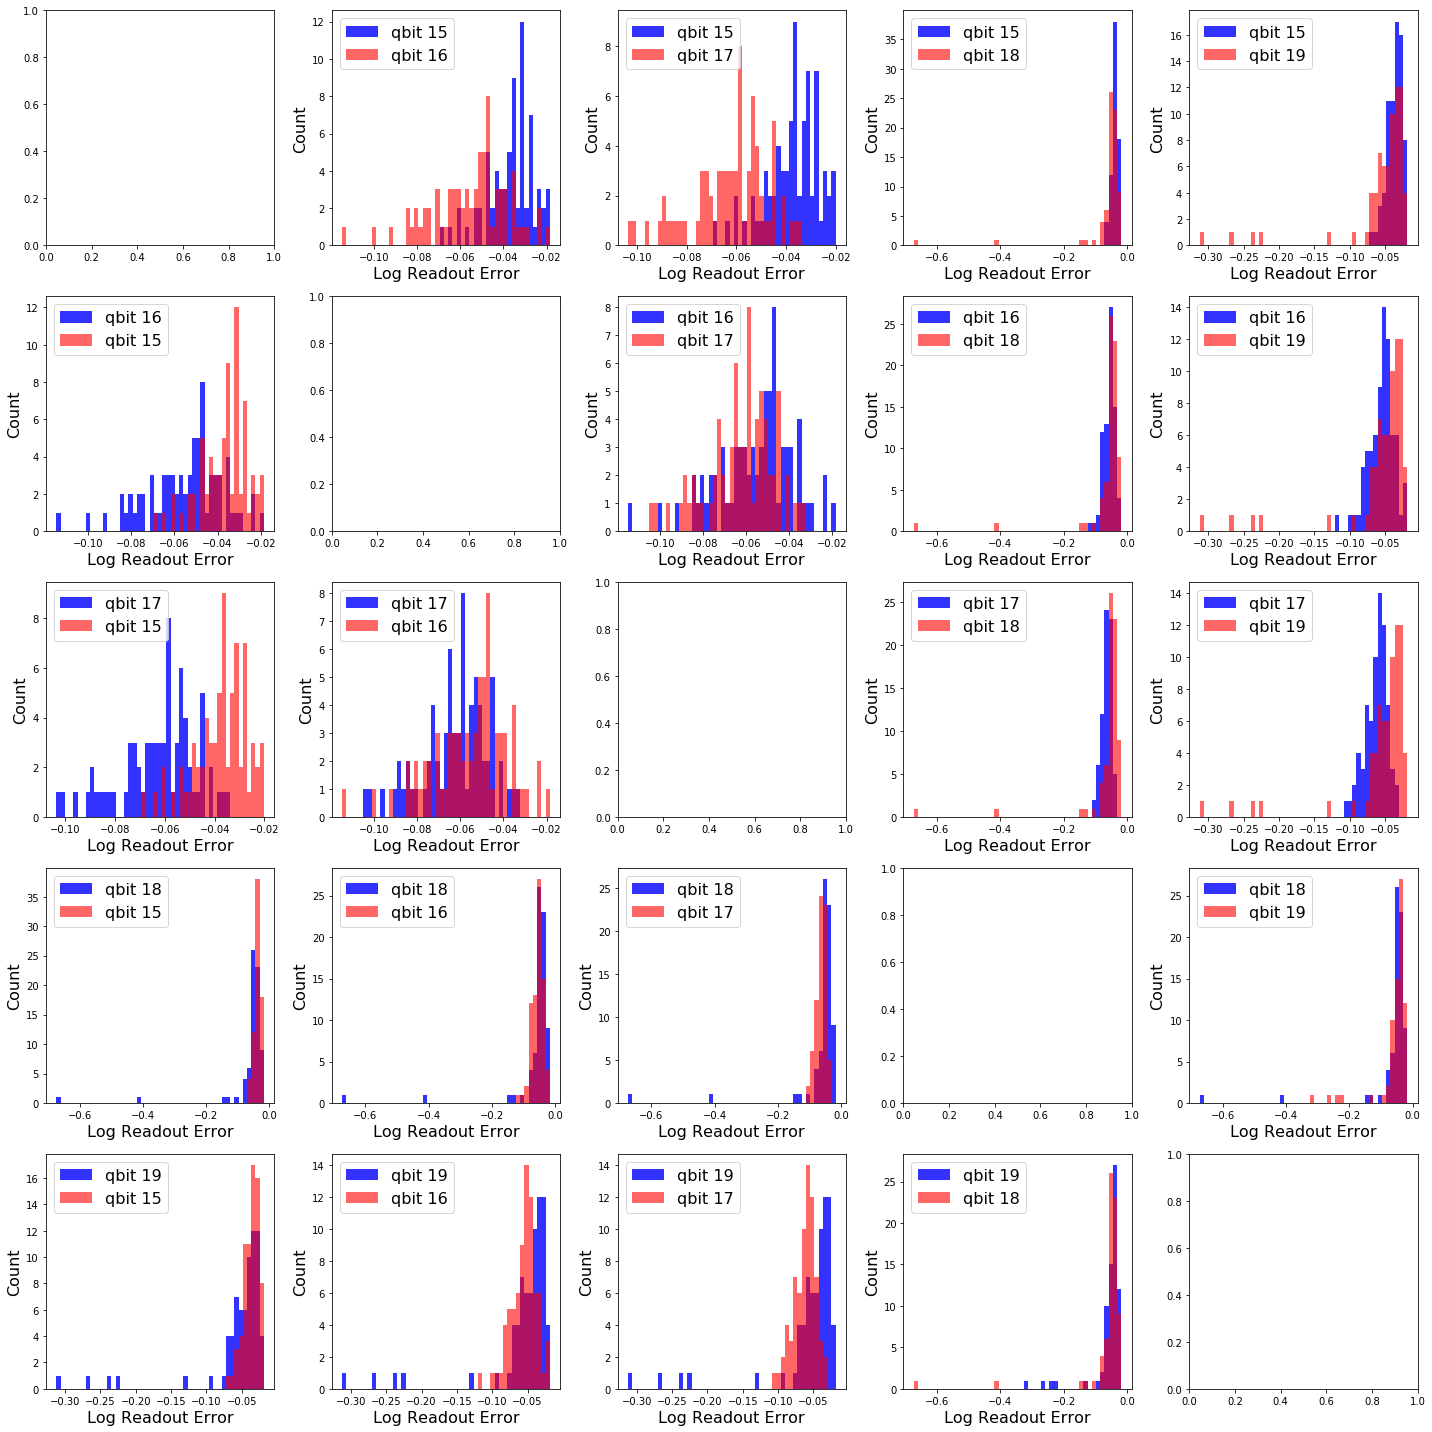

,KLD
qbit 15-16,0.630168
qbit 15-17,0.794092
qbit 15-18,0.352501
qbit 15-19,0.316100
qbit 16-15,0.630168
qbit 16-17,0.527824
qbit 16-18,0.313731
qbit 16-19,0.441497
qbit 17-15,0.794092
qbit 17-16,0.527824


In [31]:
qbit_data_all = []
for x in range(10,15):
    qbit_data_all.append(readout_fid_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 15
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(qbit_data_all[i]))
            qbit_j = np.log(np.array(qbit_data_all[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel('Log Readout Error', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'readout_fid_ibm_qbit15-19.pdf')
plt.savefig(figure_path + 'readout_fid_ibm_qbit15-19.png')
plt.show()

JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

## U2 Error

In [32]:
u2_err_boeblingen = data_dir + historic_dir + 'u2_err_boeblingen.csv'
u2_err_df_initial = pd.read_csv(u2_err_boeblingen, usecols=['val', 'bit'])
display(u2_err_df_initial.head())

temp = defaultdict(list)
bits = u2_err_df_initial.loc[:, 'bit']
vals = u2_err_df_initial.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
u2_err_boeblingen_dict = temp

,val,bit
0,0.000294,0
1,0.001362,19
2,0.000256,17
3,0.000602,4
4,0.000283,15


0: 60
1: 63
2: 60
3: 63
4: 61
5: 60
6: 63
7: 60
8: 63
9: 60
10: 63
11: 60
12: 63
13: 60
14: 63
15: 60
16: 63
17: 60
18: 63
19: 60


In [33]:
u2_err_ourense = data_dir + historic_dir + 'u2_err_ourense.csv'
u2_err_df_ourense = pd.read_csv(u2_err_ourense, usecols=['val', 'bit'])
display(u2_err_df_ourense.head())

temp = defaultdict(list)
bits = u2_err_df_ourense.loc[:, 'bit']
vals = u2_err_df_ourense.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
u2_err_ourense_dict = temp

,val,bit
0,0.000429,0
1,0.000339,3
2,0.000291,2
3,0.000402,4
4,0.000392,1


0: 64
1: 64
2: 64
3: 64
4: 64


In [34]:
u2_err_poughkeepsie = data_dir + historic_dir + 'u2_err_poughkeepsie.csv'
u2_err_df_poughkeepsie = pd.read_csv(u2_err_poughkeepsie, usecols=['val', 'bit'])
display(u2_err_df_poughkeepsie.head())

temp = defaultdict(list)
bits = u2_err_df_poughkeepsie.loc[:, 'bit']
vals = u2_err_df_poughkeepsie.loc[:,'val']
for bit, val in zip(bits, vals):
    temp[bit].append(val)
# Get minimum number of frequency times
for key,vals in sorted(temp.items()):
    print("{}: {}".format(key, len(vals)))
u2_err_poughkeepsie_dict = temp

,val,bit
0,0.001186,0
1,0.001245,2
2,0.000919,3
3,0.001255,4
4,0.001411,5


0: 209
1: 209
2: 209
3: 209
4: 209
5: 209
6: 209
7: 210
8: 209
9: 209
10: 213
11: 209
12: 213
13: 209
14: 209
15: 210
16: 209
17: 213
18: 210
19: 209


In [35]:
u2_err_all_dict = mergeDict(u2_err_boeblingen_dict,u2_err_ourense_dict, u2_err_poughkeepsie_dict)
for key,vals in sorted(u2_err_all_dict.items()):
    vals = np.ndarray.flatten(np.array(vals))
for key,vals in sorted(u2_err_all_dict.items()):
    print("{}: {}".format(key, len(vals)))

0: 333
1: 336
2: 333
3: 336
4: 334
5: 269
6: 272
7: 270
8: 272
9: 269
10: 276
11: 269
12: 276
13: 269
14: 272
15: 270
16: 272
17: 273
18: 273
19: 269


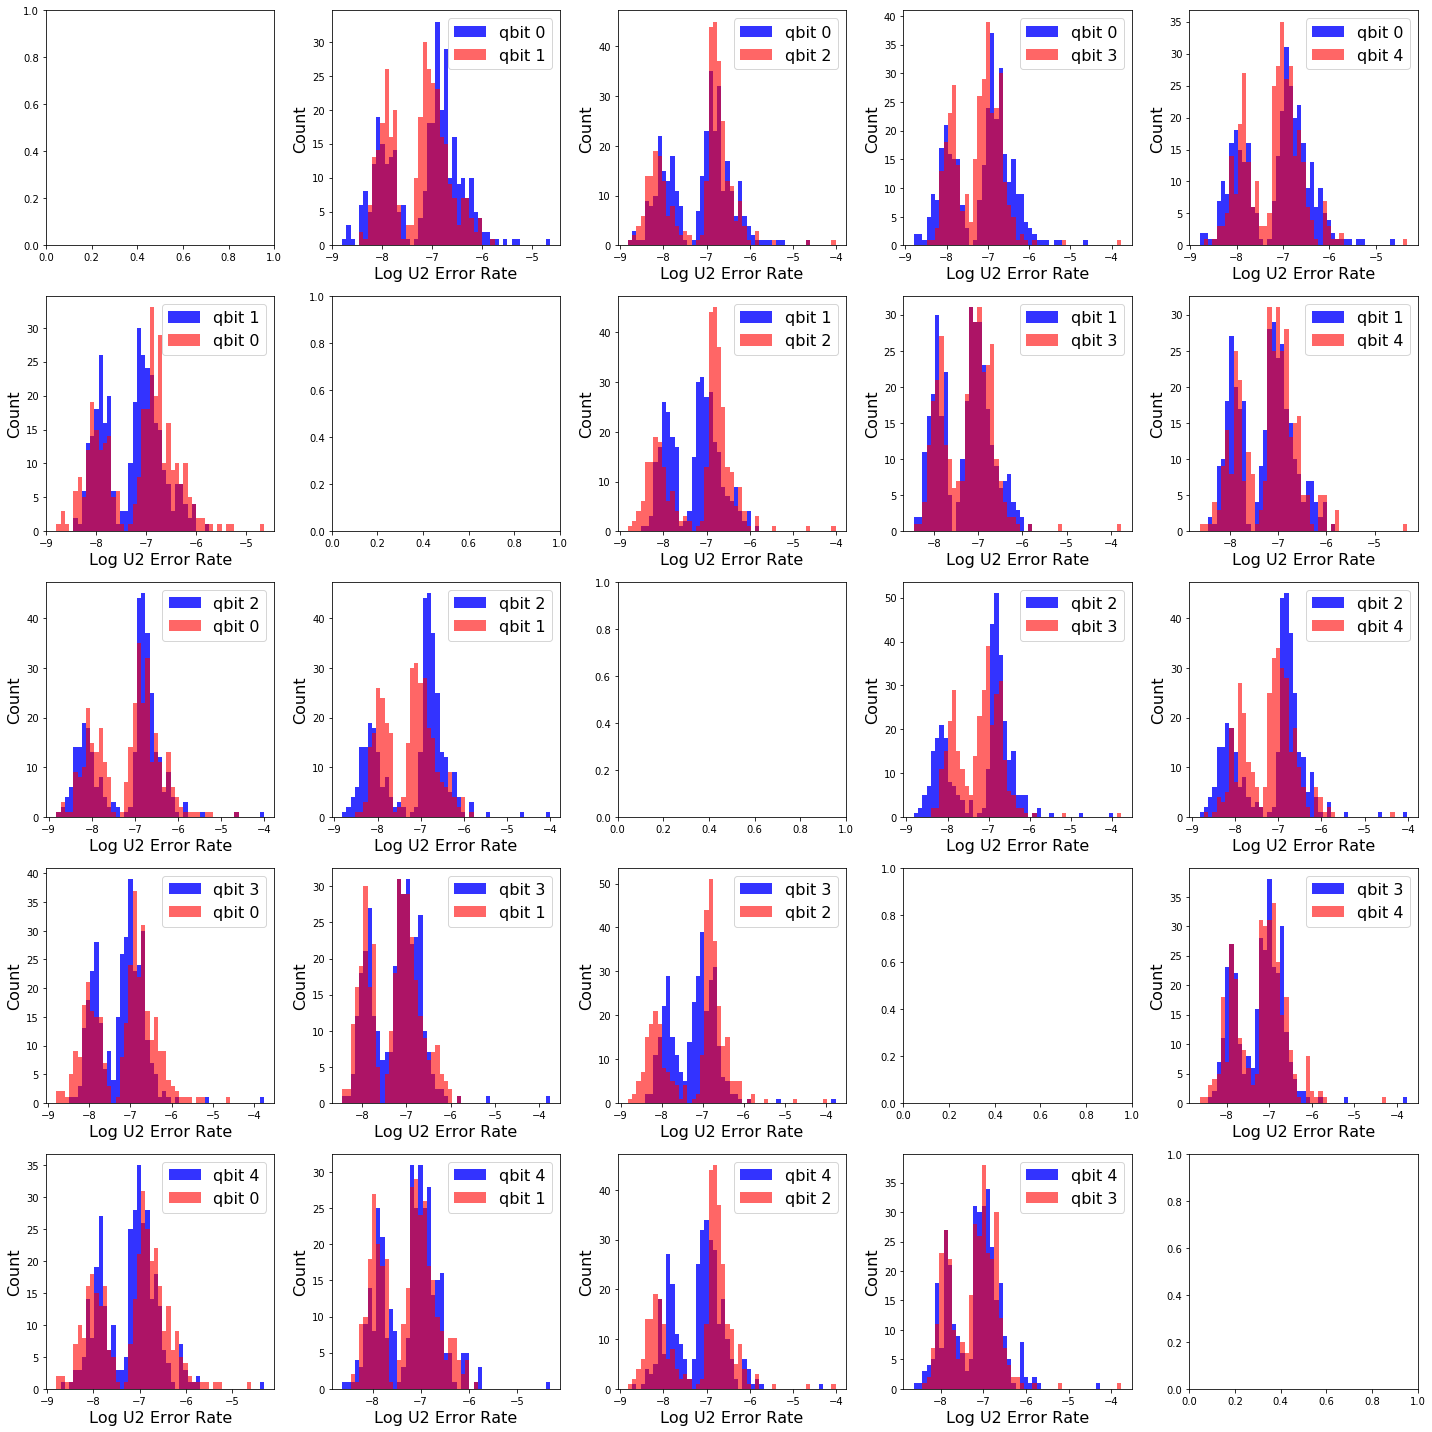

In [36]:
qbit_data_all = []
for x in range(5):
    qbit_data_all.append(u2_err_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(qbit_data_all[i]))
            qbit_j = np.log(np.array(qbit_data_all[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j))
            ax1.set_xlabel('Log U2 Error Rate', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'u2_err_ibm_qbit0-4.pdf')
plt.savefig(figure_path + 'u2_err_ibm_qbit0-4.png')
plt.show()

In [37]:
JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i,j))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

,KLD
qbit 0-1,0.324931
qbit 0-2,0.295748
qbit 0-3,0.341543
qbit 0-4,0.300411
qbit 1-0,0.324931
qbit 1-2,0.468450
qbit 1-3,0.211994
qbit 1-4,0.293236
qbit 2-0,0.295748
qbit 2-1,0.468450


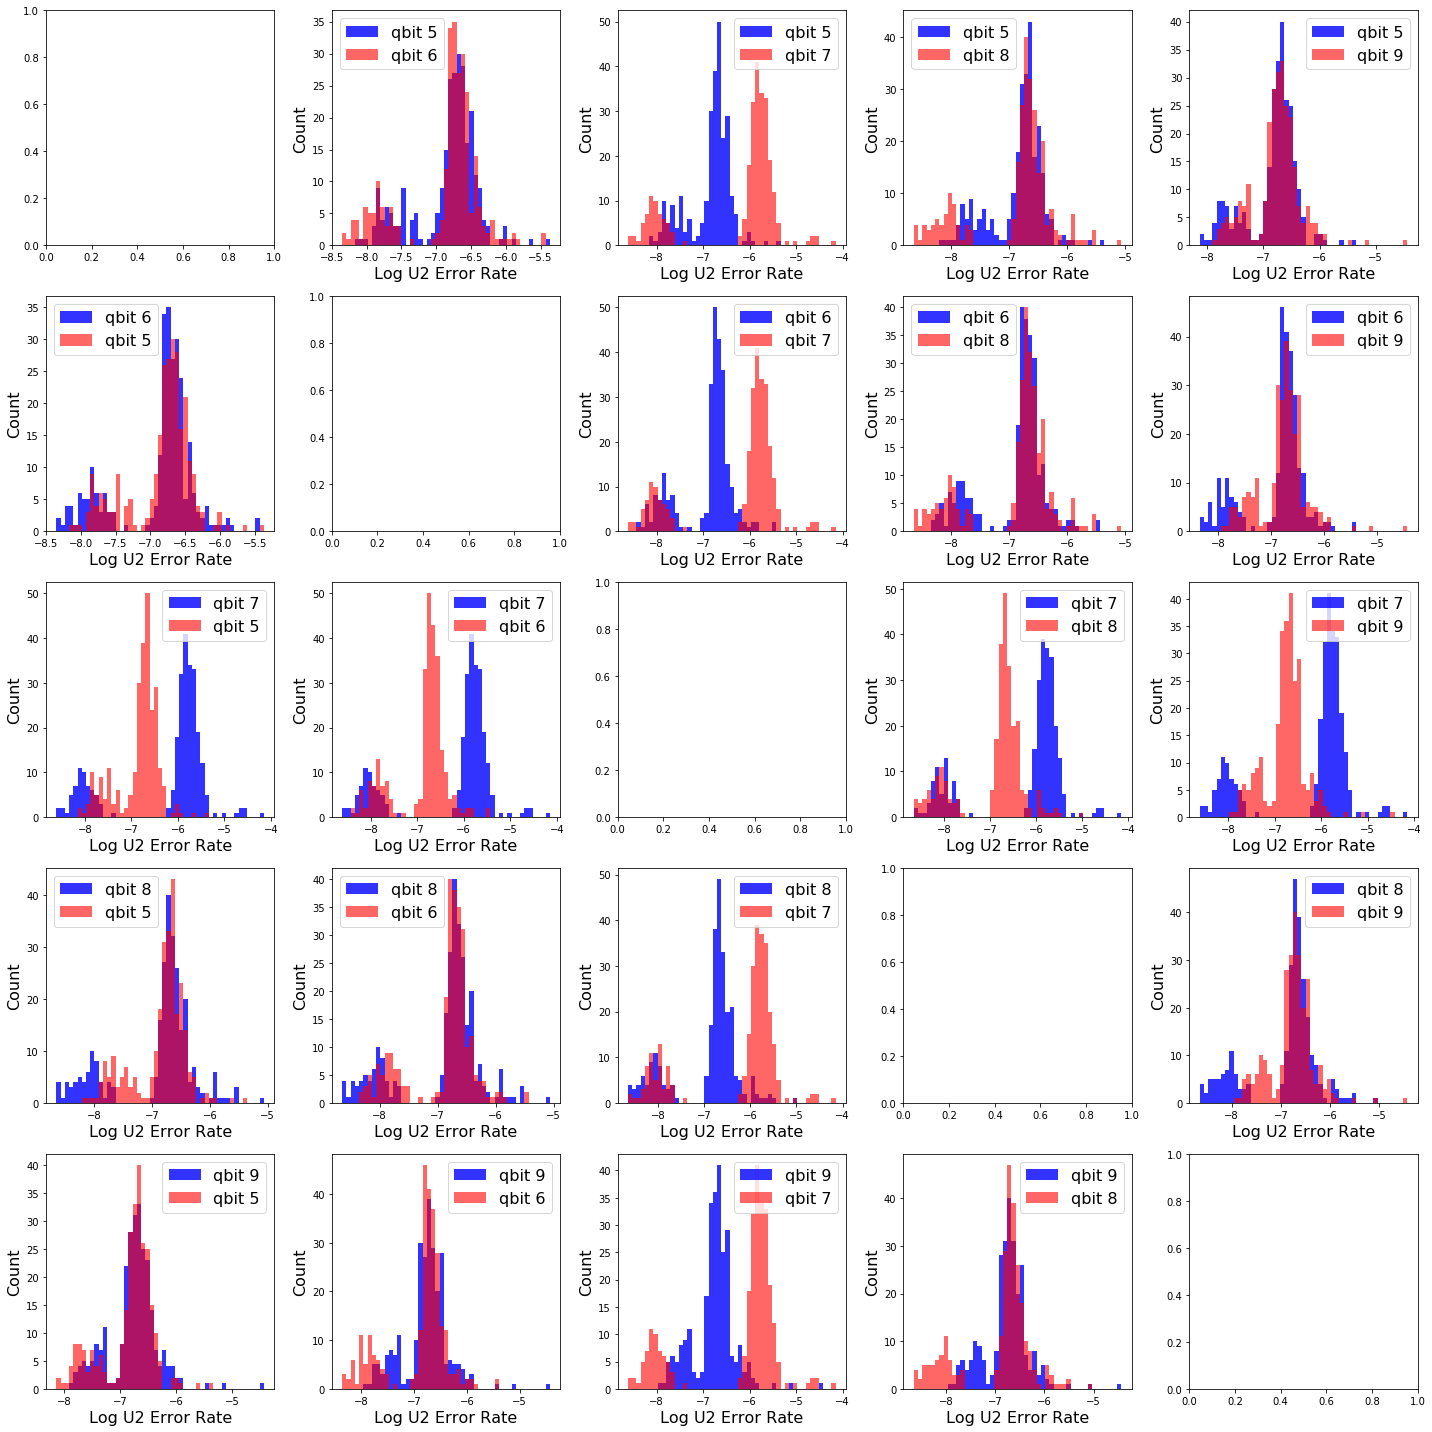

,KLD
qbit 5-6,0.336929
qbit 5-7,0.909217
qbit 5-8,0.421978
qbit 5-9,0.245108
qbit 6-5,0.336929
qbit 6-7,0.854019
qbit 6-8,0.302666
qbit 6-9,0.397442
qbit 7-5,0.909217
qbit 7-6,0.854019


In [38]:
qbit_data_all = []
for x in range(5,10):
    qbit_data_all.append(u2_err_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 5
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(qbit_data_all[i]))
            qbit_j = np.log(np.array(qbit_data_all[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel('Log U2 Error Rate', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'u2_err_ibm_qbit5-9.pdf')
plt.savefig(figure_path + 'u2_err_ibm_qbit5-9.png')
plt.show()
JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

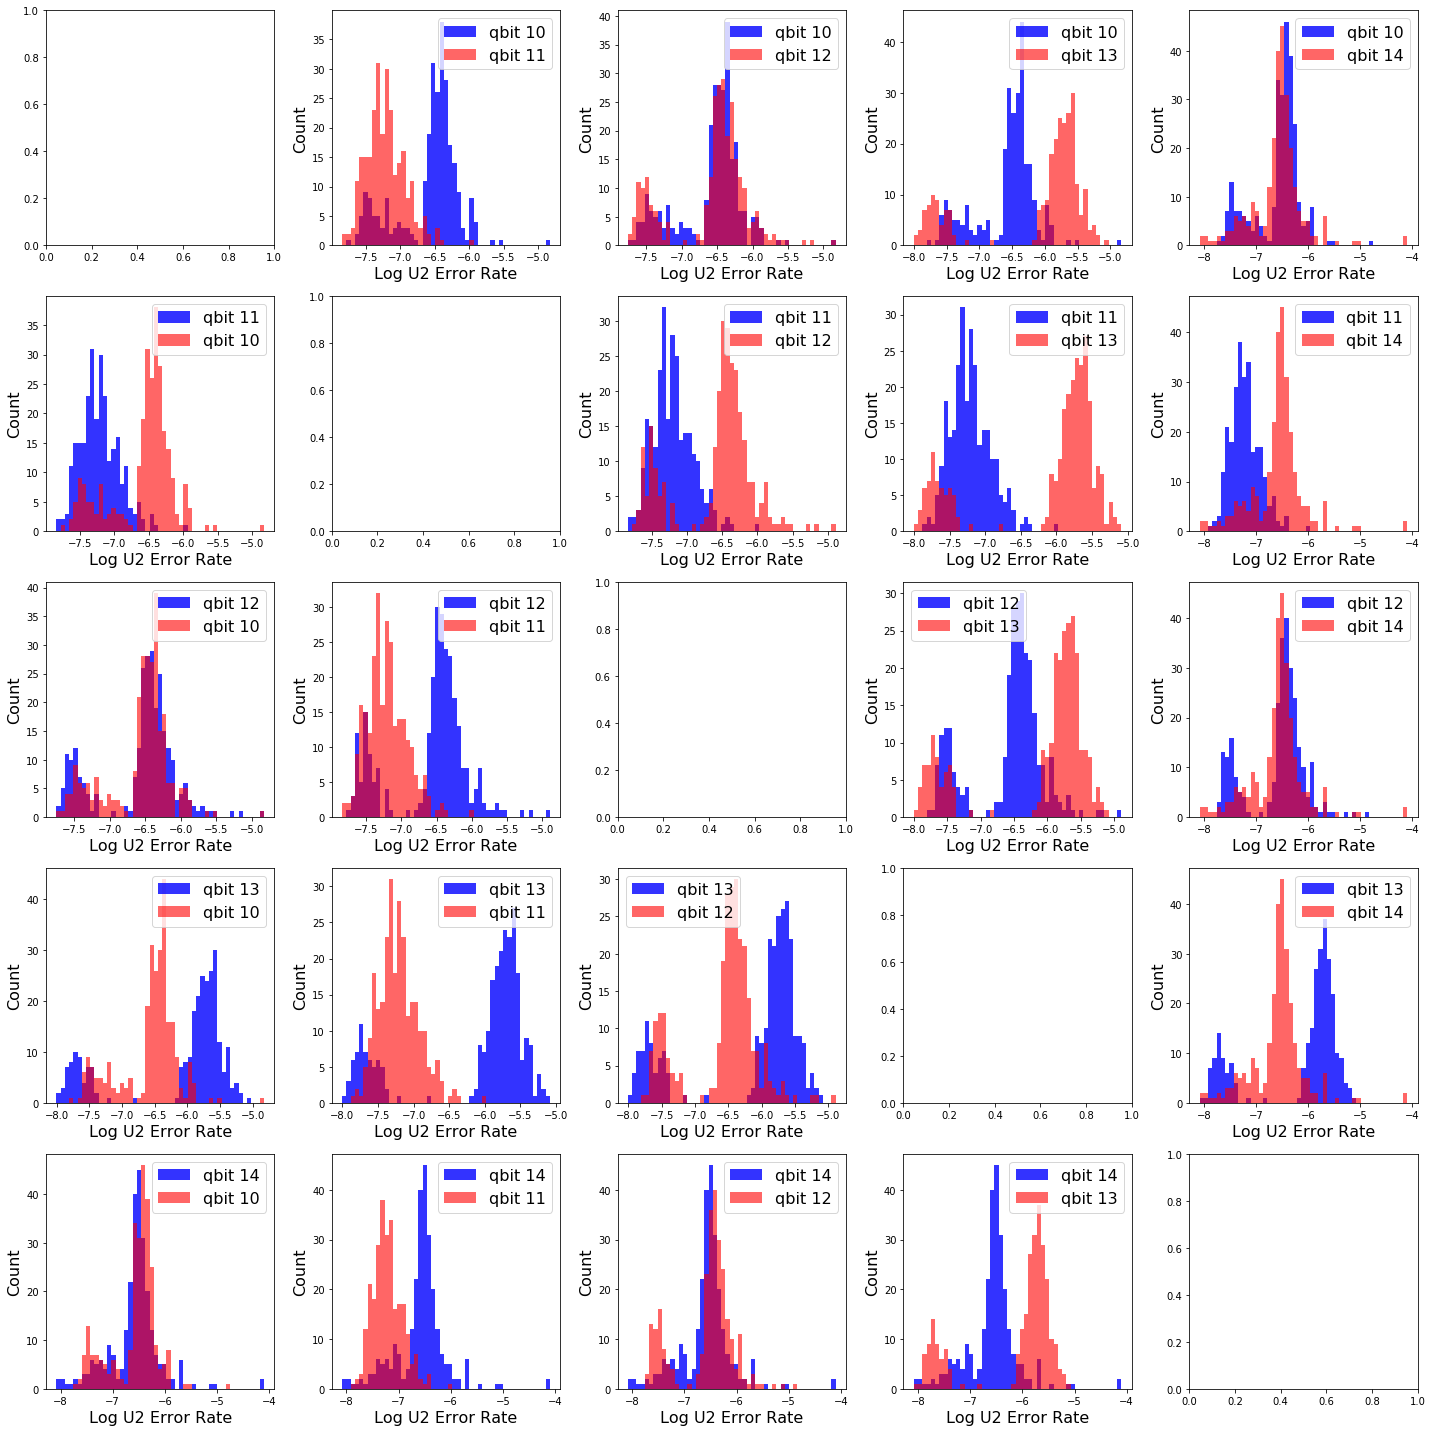

,KLD
qbit 10-11,0.712696
qbit 10-12,0.292343
qbit 10-13,0.882576
qbit 10-14,0.331432
qbit 11-10,0.712696
qbit 11-12,0.764436
qbit 11-13,0.884445
qbit 11-14,0.709265
qbit 12-10,0.292343
qbit 12-11,0.764436


In [39]:
qbit_data_all = []
for x in range(10,15):
    qbit_data_all.append(u2_err_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 10
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(qbit_data_all[i]))
            qbit_j = np.log(np.array(qbit_data_all[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel('Log U2 Error Rate', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'u2_err_ibm_qbit10-14.pdf')
plt.savefig(figure_path + 'u2_err_ibm_qbit10-14.png')
plt.show()
JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

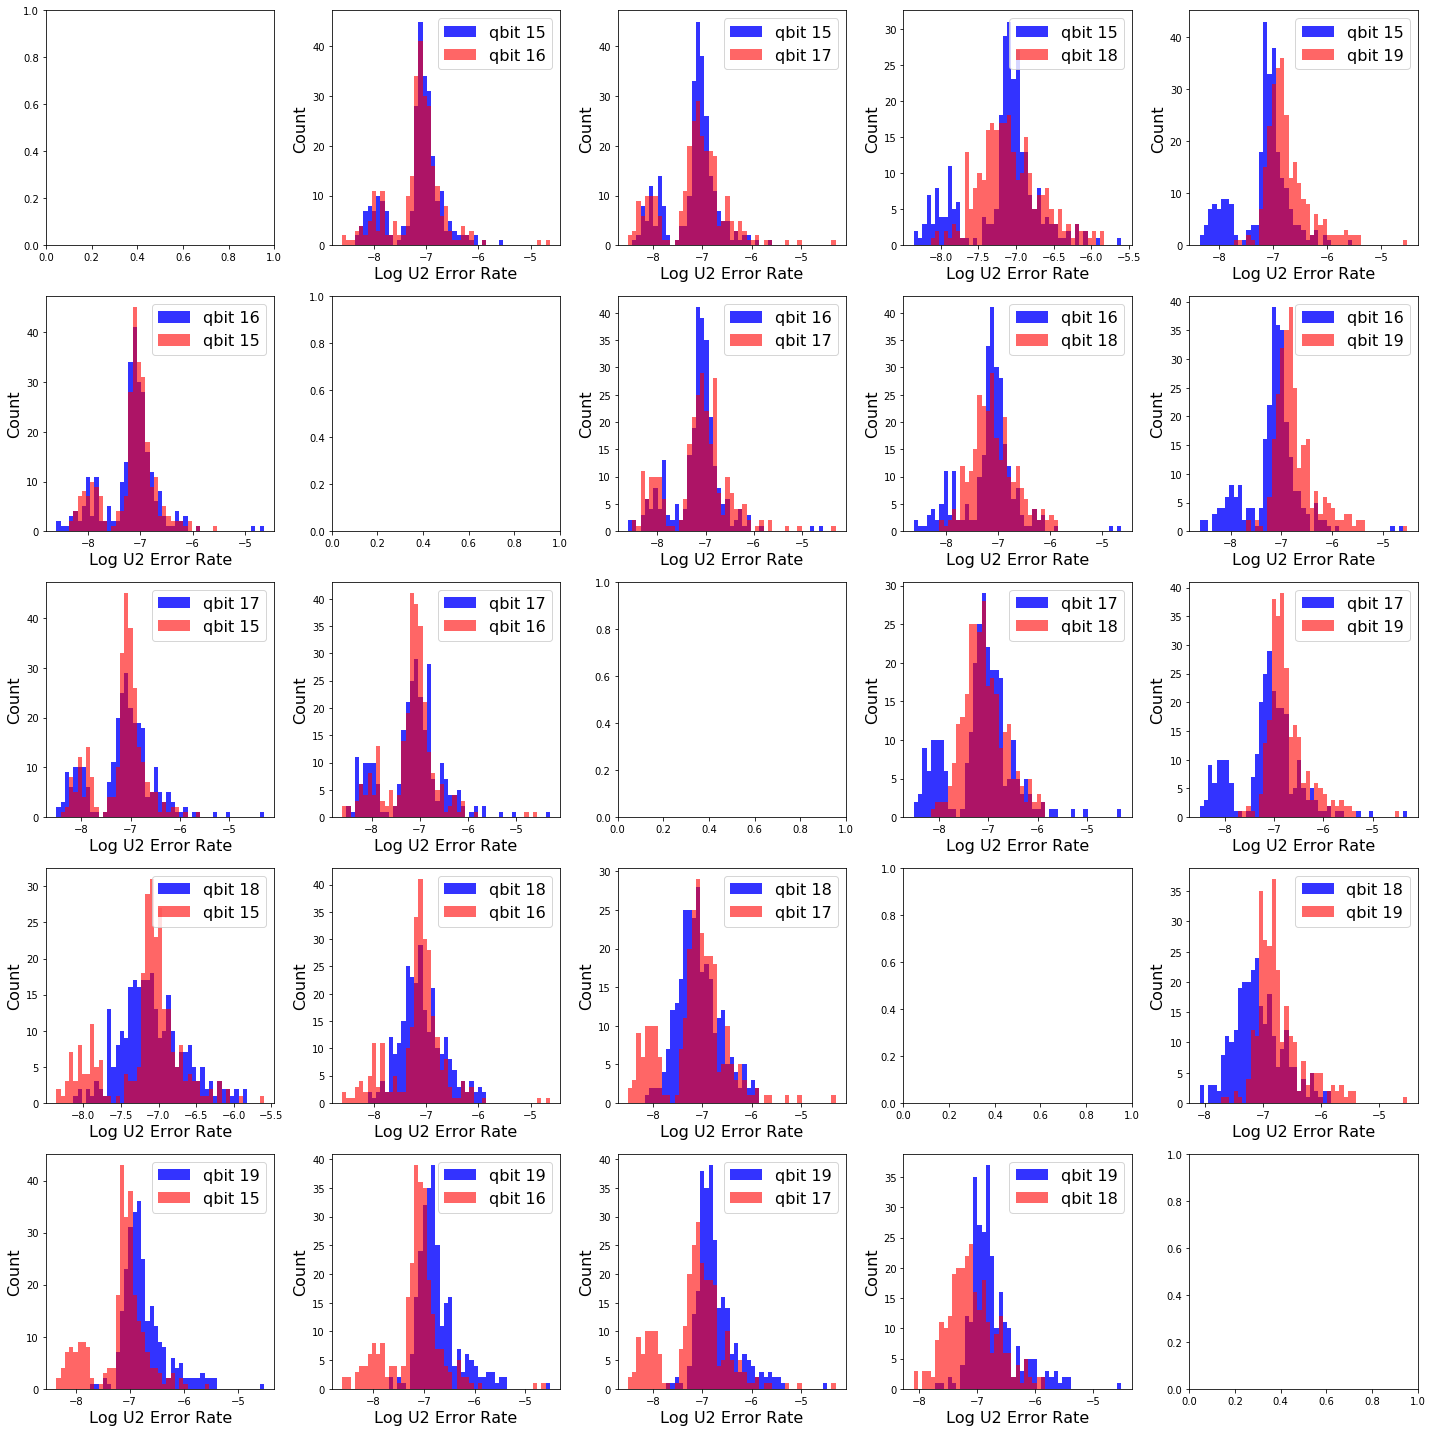

,KLD
qbit 15-16,0.248807
qbit 15-17,0.281298
qbit 15-18,0.446723
qbit 15-19,0.491035
qbit 16-15,0.248807
qbit 16-17,0.290283
qbit 16-18,0.368304
qbit 16-19,0.517827
qbit 17-15,0.281298
qbit 17-16,0.290283


In [40]:
qbit_data_all = []
for x in range(15,20):
    qbit_data_all.append(u2_err_all_dict[x])
qbit_data_all = np.array(qbit_data_all)

fig = plt.figure(figsize=(20,20))
    
grid_x = 5
grid_y = 5
binsize = 50
base_qbit = 15
grid = mpl.gridspec.GridSpec(grid_x, grid_y)
count = 0
qbit_hist_data_all_blue = np.zeros((5,5,binsize-1))
qbit_hist_data_all_red = np.zeros((5,5,binsize-1))

for i in range(grid_x):
    for j in range(grid_y):
        ax1 = plt.subplot(grid[i,j])
        if i != j:
            qbit_i = np.log(np.array(qbit_data_all[i]))
            qbit_j = np.log(np.array(qbit_data_all[j]))
            best_bins_min = np.minimum(qbit_i.min(), qbit_j.min()) 
            best_bins_max = np.maximum(qbit_i.max(), qbit_j.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            temp_blue = plt.hist(qbit_i,color='blue', bins=bins_best, alpha=alpha_blue, label='qbit {}'.format(i+base_qbit))
            temp_red = plt.hist(qbit_j,color='red', bins=bins_best, alpha=alpha_red, label='qbit {}'.format(j+base_qbit))
            ax1.set_xlabel('Log U2 Error Rate', fontsize=16)
            ax1.set_ylabel('Count', fontsize=16)
            #ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            qbit_hist_data_all_blue[i,j] = temp_blue[0]
            qbit_hist_data_all_red[i,j] = temp_red[0]
            count += 1
plt.tight_layout()
plt.savefig(figure_path + 'u2_err_ibm_qbit15-19.pdf')
plt.savefig(figure_path + 'u2_err_ibm_qbit15-19.png')
plt.show()
JSD_scores = np.zeros((grid_x, grid_y))
JSD_scores_list = []
qbit_list = []
for i in range(grid_x):
    for j in range(grid_y):
        if i != j:
            qbit_hist_data_all_blue[i,j] = qbit_hist_data_all_blue[i,j]/np.sum(qbit_hist_data_all_blue[i,j])
            qbit_hist_data_all_red[i,j] = qbit_hist_data_all_red[i,j]/np.sum(qbit_hist_data_all_red[i,j])
            JSD_scores[i,j] = metrics.jensenshannon(qbit_hist_data_all_blue[i,j], qbit_hist_data_all_red[i,j])
            #print("KLD between qbit {} and qbit {}:\t{:10.4f}".format(i,j, JSD_scores[i,j]))
            qbit_list.append('qbit {}-{}'.format(i+base_qbit,j+base_qbit))
            JSD_scores_list.append(JSD_scores[i,j])
readout_fid_jsd_df = pd.DataFrame(data=JSD_scores_list, index=qbit_list, columns=['KLD'])        

display(readout_fid_jsd_df)

## Calibration Data

In [41]:
from os import listdir

from os.path import isfile, join
calibration_files = [f for f in listdir(calibration_dir) if isfile(join(calibration_dir, f))]






In [42]:
# Define dataframe for each qubit's data
calibration_df = pd.DataFrame()
counter = 0
for f in calibration_files:
    df = pd.read_csv(calibration_dir + f)
    df = df.rename({'Frecuency (GHz)':'Frequency (GHz)'},axis='columns')
    calibration_df = calibration_df.append(df,sort=False)
    counter += 1
display(calibration_df.head())
display(calibration_df.describe())

,Qubit,T1 (µs),T2 (µs),Frequency (GHz),Readout error,Single-qubit U2 error rate,CNOT error rate,Single-qubit U3 error rate
0,Q0,114.834868,16.805490,4.795984,0.043,0.000357,cx0_1: 9.376e-3,NaN
1,Q1,79.723968,110.365689,4.940052,0.014,0.000457,"cx1_0: 9.376e-3, cx1_2: 6.387e-3, cx1_3: 1.214e-2",NaN
2,Q2,116.496576,157.594091,4.833252,0.013,0.000296,cx2_1: 6.387e-3,NaN
3,Q3,119.175936,103.300998,4.807984,0.022,0.000732,"cx3_1: 1.214e-2, cx3_4: 2.101e-2",NaN
4,Q4,54.687467,31.083684,4.750062,0.200,0.007921,cx4_3: 2.101e-2,NaN


,T1 (µs),T2 (µs),Frequency (GHz),Readout error,Single-qubit U2 error rate,Single-qubit U3 error rate
count,7890.000000,7890.000000,7890.000000,7890.000000,1846.000000,6044.000000
mean,67.057766,64.942952,4.939850,0.055956,0.002305,0.030189
std,23.592051,34.908292,0.183280,0.054532,0.011902,0.228221
min,2.935425,2.665022,4.499767,0.006000,0.000225,0.000370
25%,50.883288,38.192794,4.807991,0.028000,0.000602,0.001390
50%,64.535768,63.666587,4.955690,0.040000,0.000941,0.002572
75%,81.091786,88.257912,5.044478,0.061800,0.001756,0.004702
max,181.984360,231.551674,5.426123,0.473800,0.407949,2.000000


### Split all calibration data into qubit specific dataframes (this case only q0-q4)

In [43]:
q0_df = calibration_df[calibration_df.loc[:,'Qubit']=='Q0'].drop(['Qubit'],axis=1)
q1_df = calibration_df[calibration_df.loc[:,'Qubit']=='Q1'].drop(['Qubit'],axis=1)
q2_df = calibration_df[calibration_df.loc[:,'Qubit']=='Q2'].drop(['Qubit'],axis=1)
q3_df = calibration_df[calibration_df.loc[:,'Qubit']=='Q3'].drop(['Qubit'],axis=1)
q4_df = calibration_df[calibration_df.loc[:,'Qubit']=='Q4'].drop(['Qubit'],axis=1)
